In [39]:
# IMPORTING NECESSARY PACKAGES
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.tree import export_graphviz

# Specify the URL of the dataset
url = "https://raw.githubusercontent.com/AAI-500-Team/aai_500_dataset/main/heart_2022_no_nans.csv"

# Use pandas to read the CSV file from the URL into a DataFrame
df = pd.read_csv(url)

## Introduction

First, we're going to understand the given dataset.

In [40]:
display(df)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246017,Virgin Islands,Male,Very good,0.0,0.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,None of them,No,...,1.78,102.06,32.28,Yes,No,No,No,"Yes, received tetanus shot but not sure what type",No,No
246018,Virgin Islands,Female,Fair,0.0,7.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,1.93,90.72,24.34,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes
246019,Virgin Islands,Male,Good,0.0,15.0,Within past year (anytime less than 12 months ...,Yes,7.0,1 to 5,No,...,1.68,83.91,29.86,Yes,Yes,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,Yes
246020,Virgin Islands,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,1.70,83.01,28.66,No,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No


In [41]:
# Use the describe method to find descriptive statistics (including the 5-summary stats)
df.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,246022.000000,246022.000000,246022.000000,246022.000000,246022.000000,246022.000000
mean,4.119026,4.167140,7.021331,1.705150,83.615179,28.668136
std,8.405844,8.102687,1.440681,0.106654,21.323156,6.513973
min,0.000000,0.000000,1.000000,0.910000,28.120000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.270000
50%,0.000000,0.000000,7.000000,1.700000,81.650000,27.460000
75%,3.000000,4.000000,8.000000,1.780000,95.250000,31.890000
max,30.000000,30.000000,24.000000,2.410000,292.570000,97.650000


### Conclusion:

The dataset has **40** columns, with numerical and categorical data. Most of the columns are categorical, with **5** numerical columns.

In [42]:
rows, columns = df.shape
print(f"Number of rows: {rows}, Number of columns: {columns}")

Number of rows: 246022, Number of columns: 40


## Data Cleaning / Preparation

Let's inspect any missing, incomplete data.

In [43]:
print(f"Number of duplicates: {df.duplicated().sum()}")
print(f"Number of missing values: {df.isnull().sum().sum()}")

Number of duplicates: 9
Number of missing values: 0


There is no missing values, but. there are duplicates. Let's drop them.
We're also going to drop BMI, since it is a function of height and weight, and there is multicollinearity.
Lastly, we're going to drop the features that are relevant to our research question.

In [44]:
# Drop duplicated
df.drop_duplicates(inplace=True)

# Drop Unrelated variables and BMI for multicollinearity with Height and Weight
df = df.drop(columns=['State', 'LastCheckupTime','BMI'])

In [45]:
# Create lists of numerical variables, categorical variables and target variable for future use
numerical_vars = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms']
categorical_includes_taget = ['Sex', 'GeneralHealth', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos','HadHeartAttack']

categorical_vars = ['Sex', 'GeneralHealth', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos']
target = 'HadHeartAttack'

print(f"Numerical variables: {numerical_vars}")
print(f"Catergorical variables: {categorical_vars}")
print(f"Target variable: {target}")

Numerical variables: ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms']
Catergorical variables: ['Sex', 'GeneralHealth', 'PhysicalActivities', 'RemovedTeeth', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']
Target variable: HadHeartAttack


## Exploratory Data Analysis

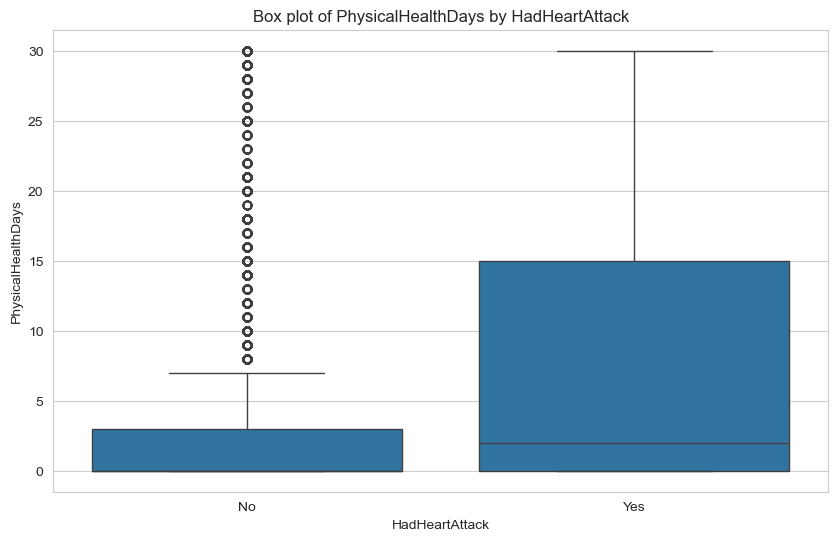

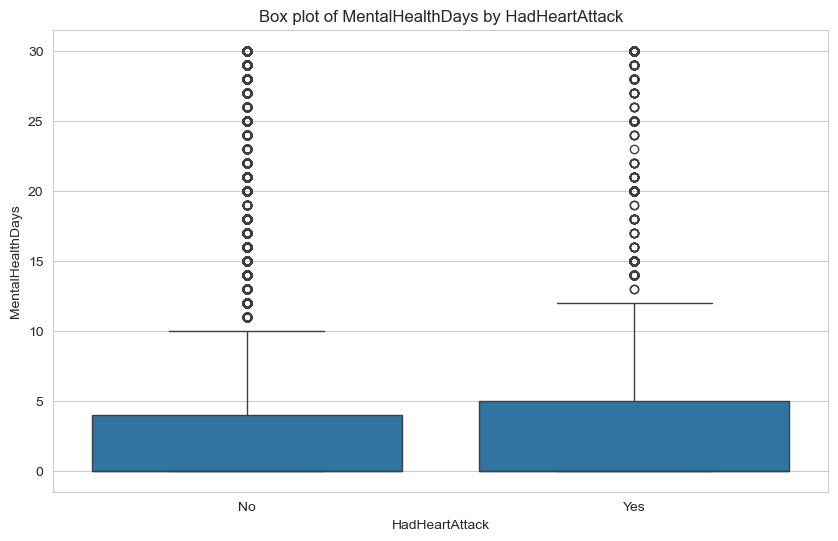

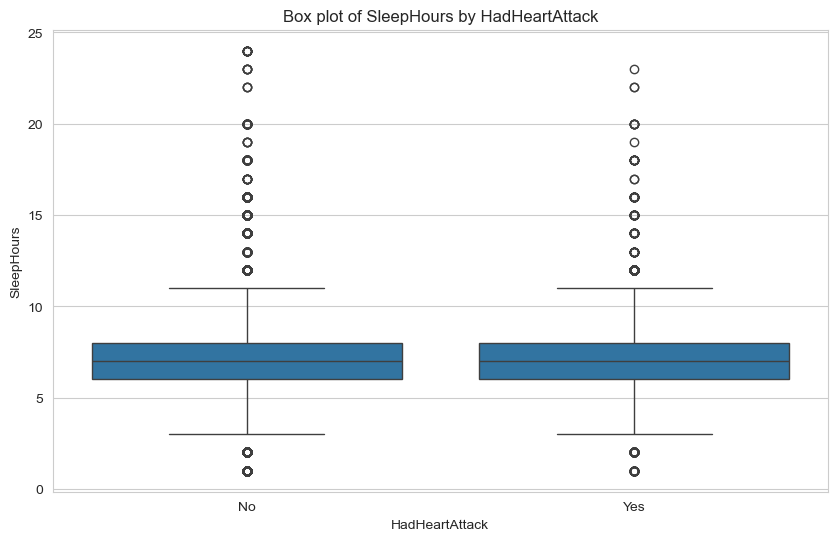

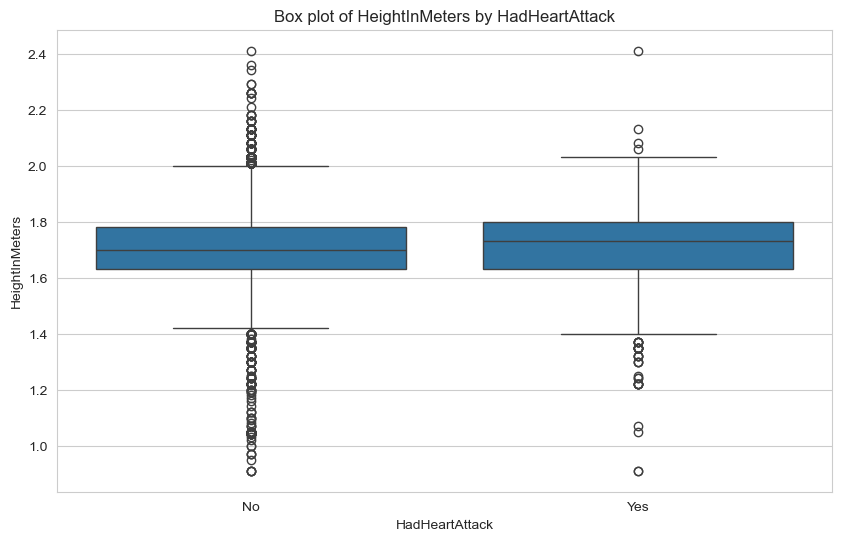

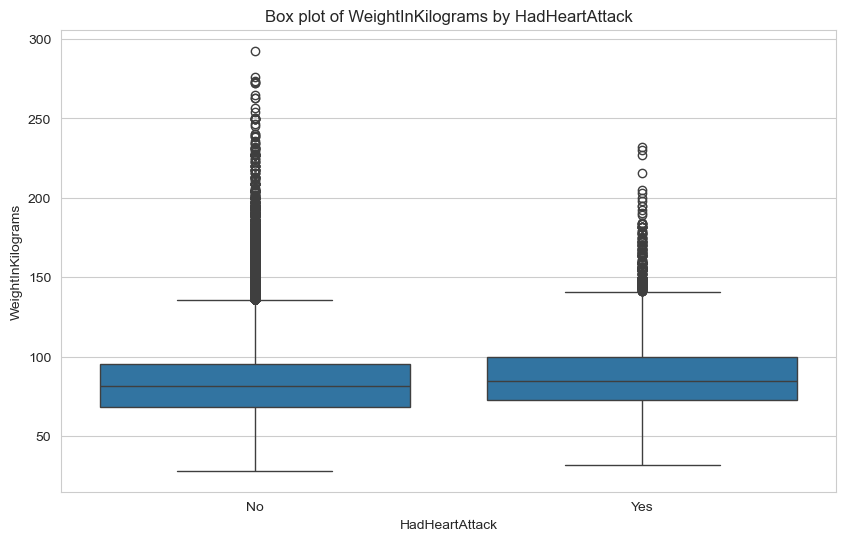

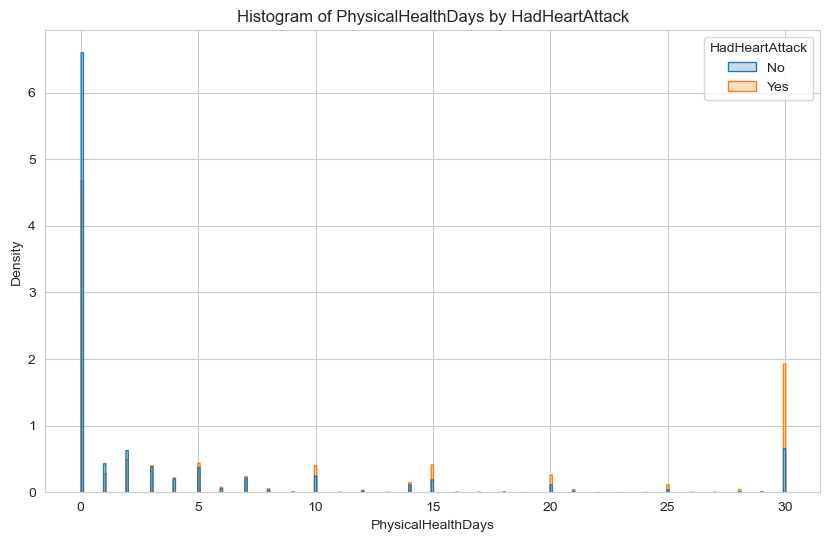

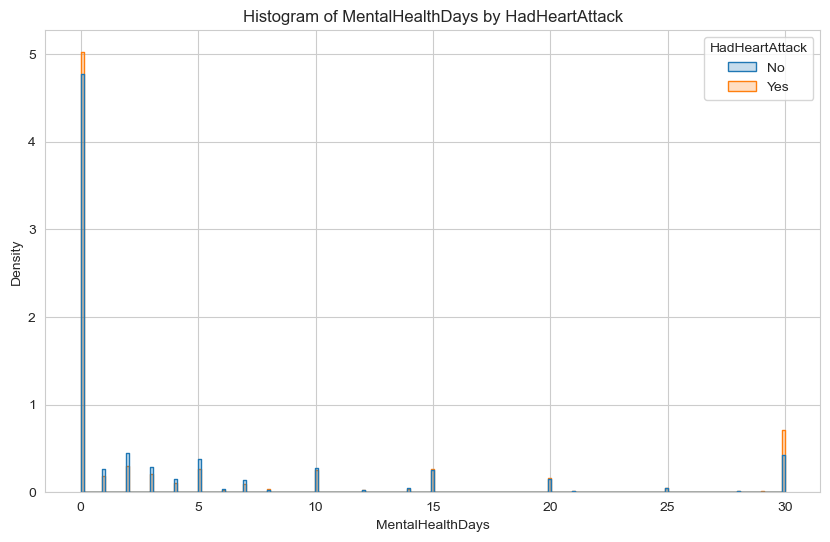

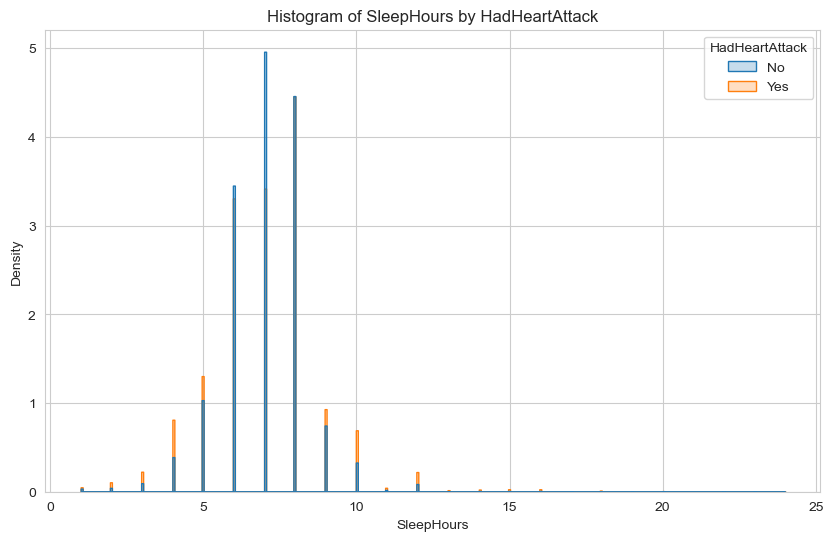

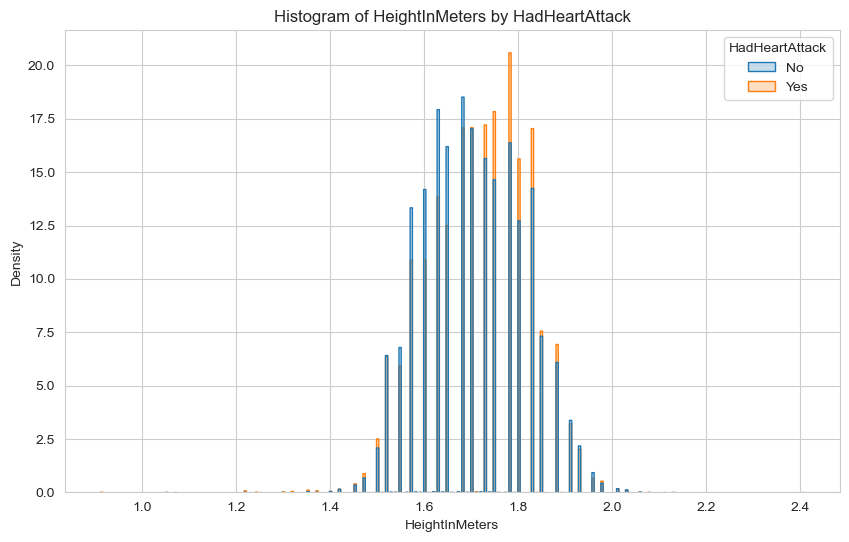

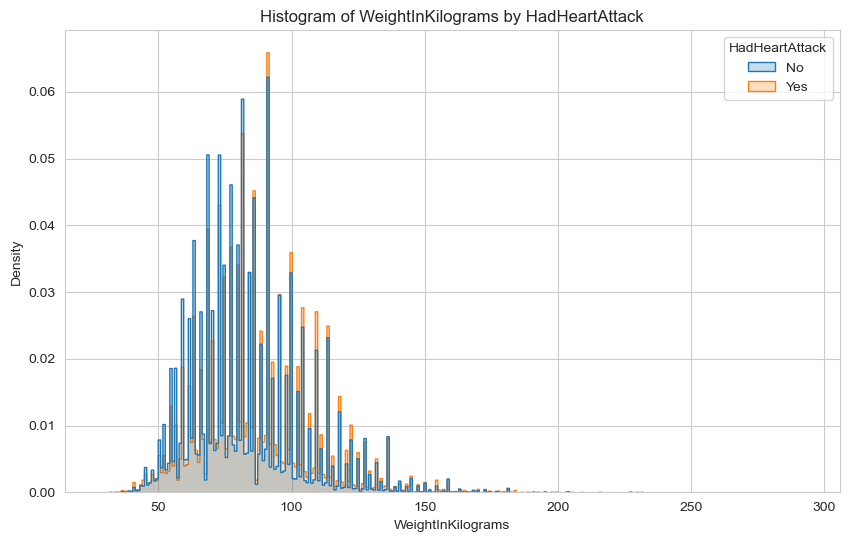

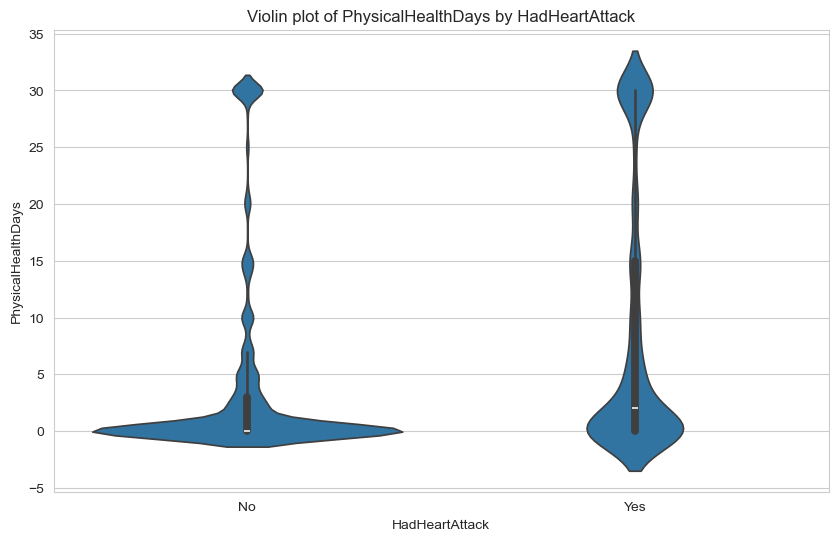

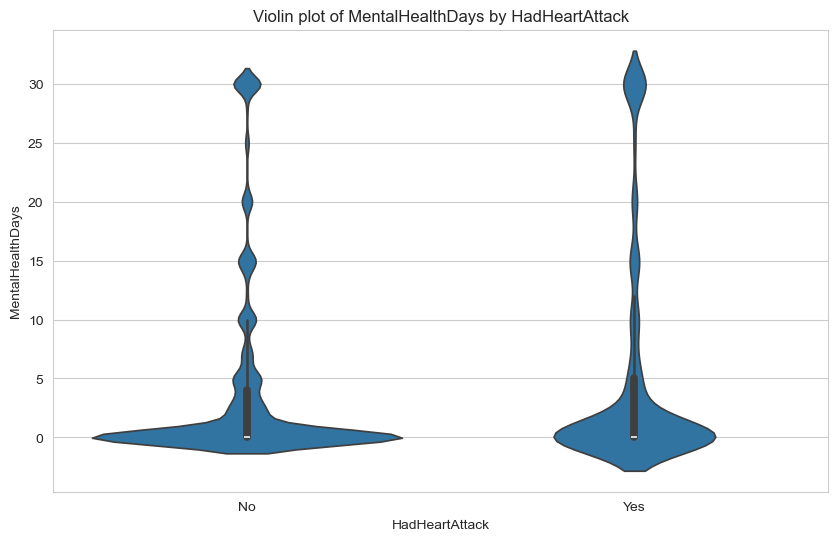

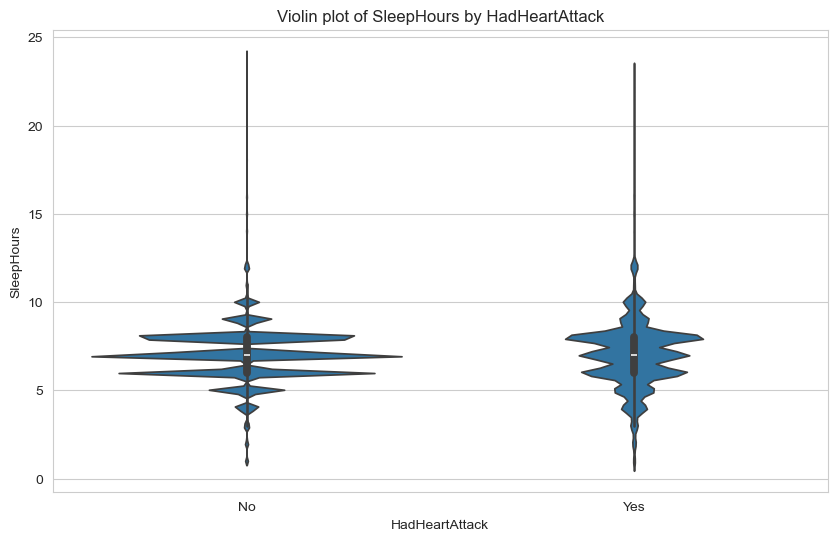

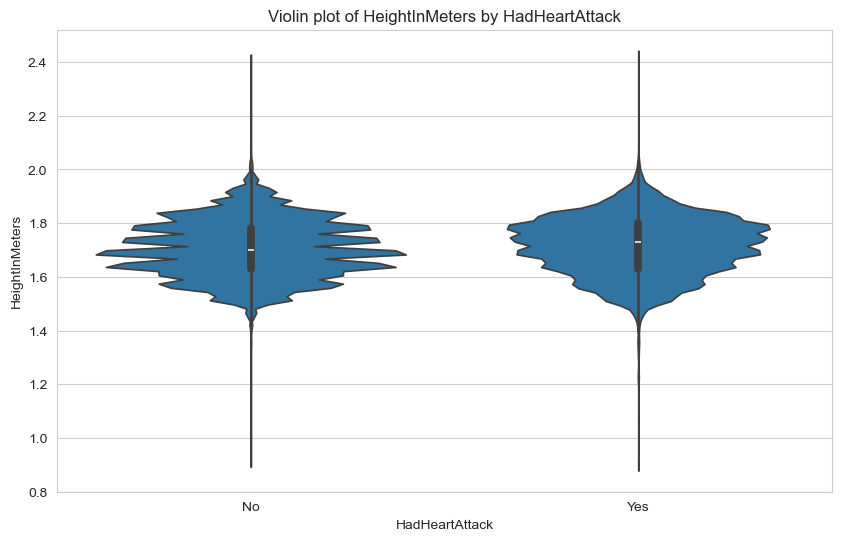

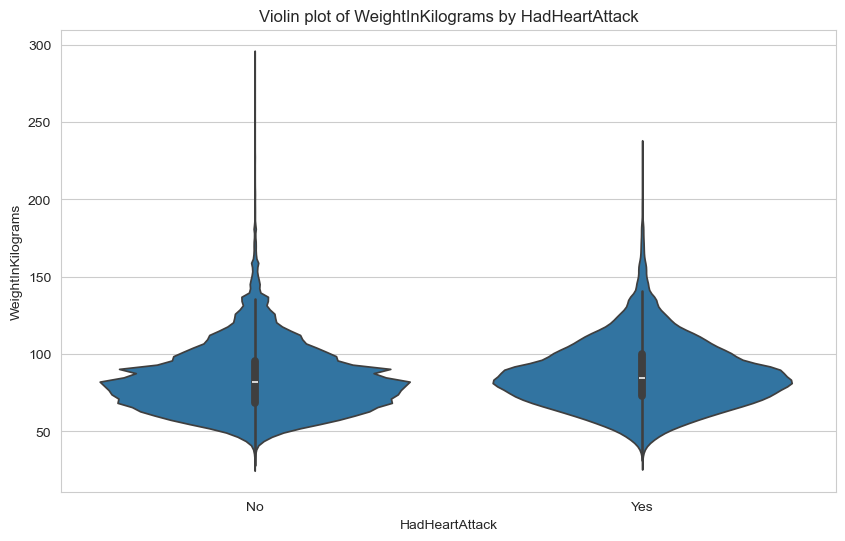

In [46]:
# Create box plots, histograms, and violin plots for numerical data
sns.set_style("whitegrid")
# Box Plots
for var in numerical_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=target, y=var, data=df)
    plt.title(f"Box plot of {var} by {target}")
    plt.show()
# Histograms
for var in numerical_vars:
    plt.figure(figsize=(10, 6))
    sns.histplot(df, x=var, hue=target, element="step", stat="density", common_norm=False)
    plt.title(f"Histogram of {var} by {target}")
    plt.show()
# Violin Plots
for var in numerical_vars:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=target, y=var, data=df)
    plt.title(f"Violin plot of {var} by {target}")
    plt.show()

HadHeartAttack      No   Yes
Sex                         
Female          122874  4932
Male            109704  8503
Chi-Squared Test for Sex and HadHeartAttack
Chi2 value = 1321.7634745274654, p-value = 2.1073833823909984e-289



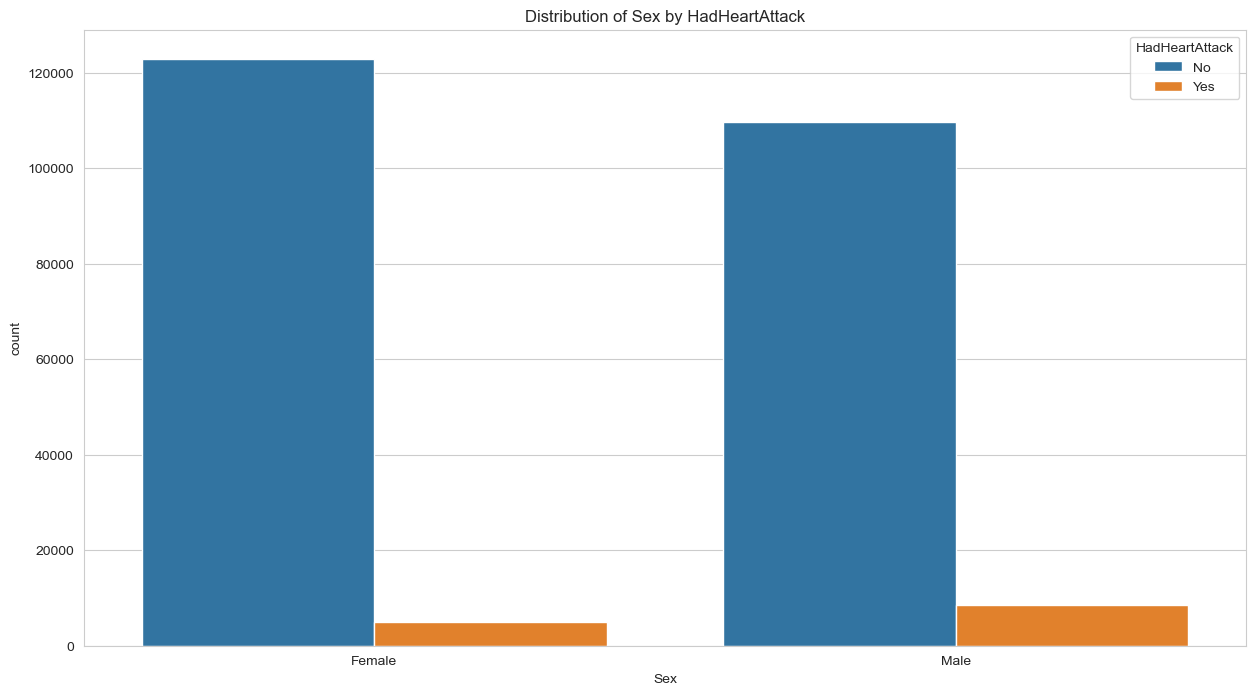

HadHeartAttack     No   Yes
GeneralHealth              
Excellent       40928   594
Fair            26910  3748
Good            72808  4599
Poor             7406  2024
Very good       84526  2470
Chi-Squared Test for GeneralHealth and HadHeartAttack
Chi2 value = 9893.539444125969, p-value = 0.0



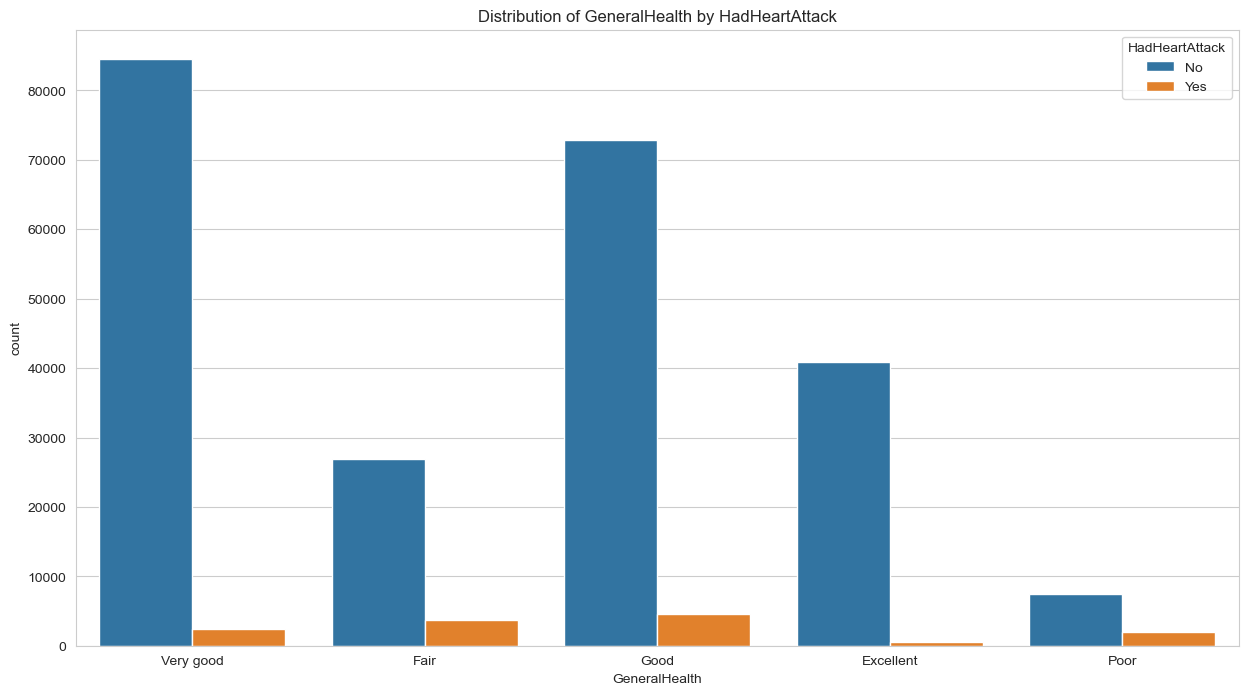

HadHeartAttack          No   Yes
PhysicalActivities              
No                   49782  4921
Yes                 182796  8514
Chi-Squared Test for PhysicalActivities and HadHeartAttack
Chi2 value = 1701.5150212822982, p-value = 0.0



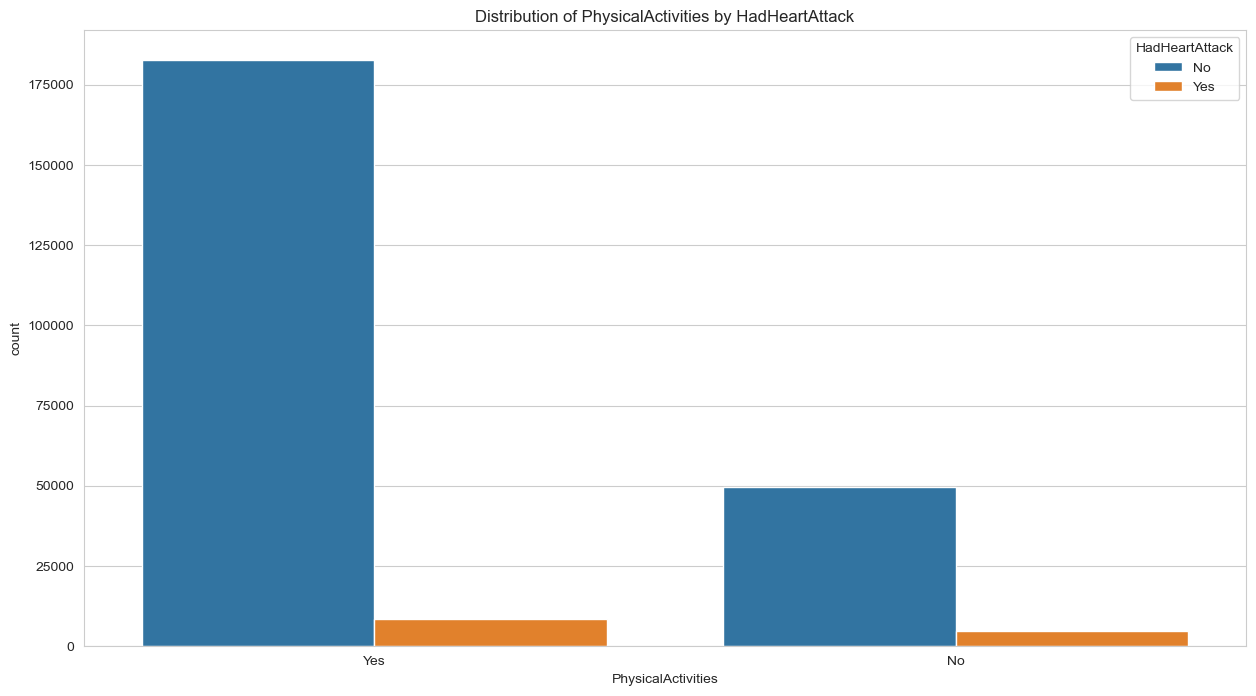

HadHeartAttack              No   Yes
RemovedTeeth                        
1 to 5                   70342  4359
6 or more, but not all   22944  3005
All                      11476  2302
None of them            127816  3769
Chi-Squared Test for RemovedTeeth and HadHeartAttack
Chi2 value = 6996.544849252672, p-value = 0.0



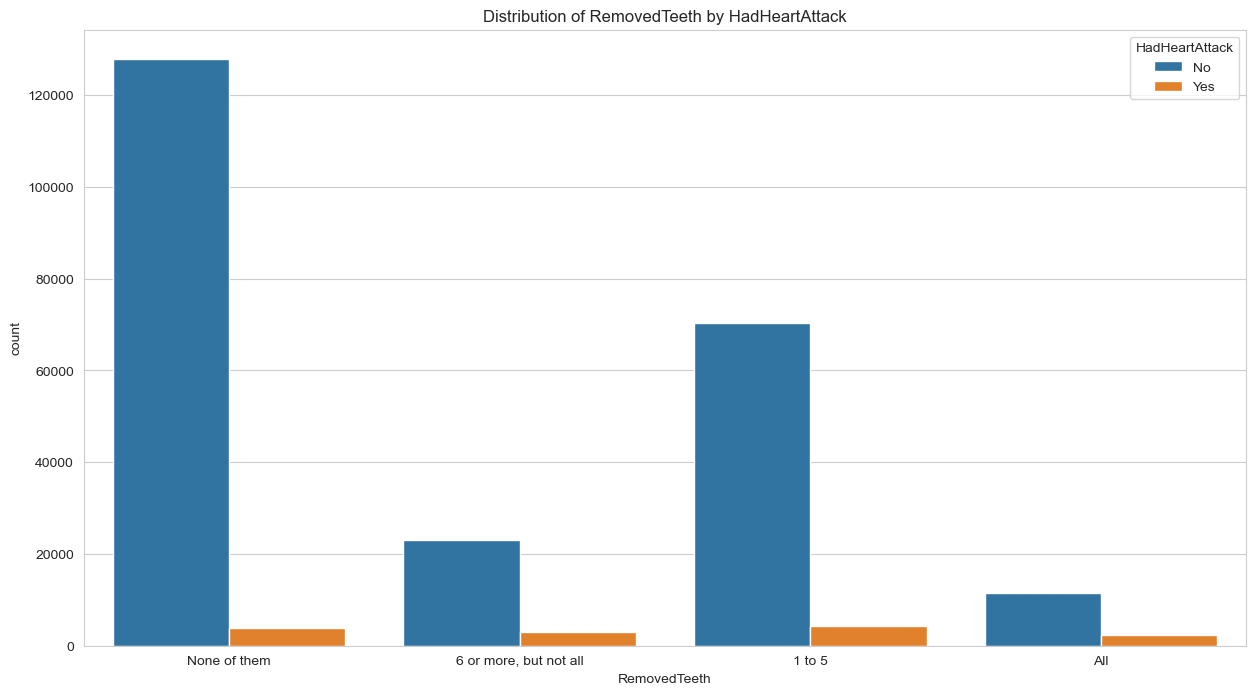

HadHeartAttack      No   Yes
HadAngina                   
No              224397  6663
Yes               8181  6772
Chi-Squared Test for HadAngina and HadHeartAttack
Chi2 value = 48906.22074894924, p-value = 0.0



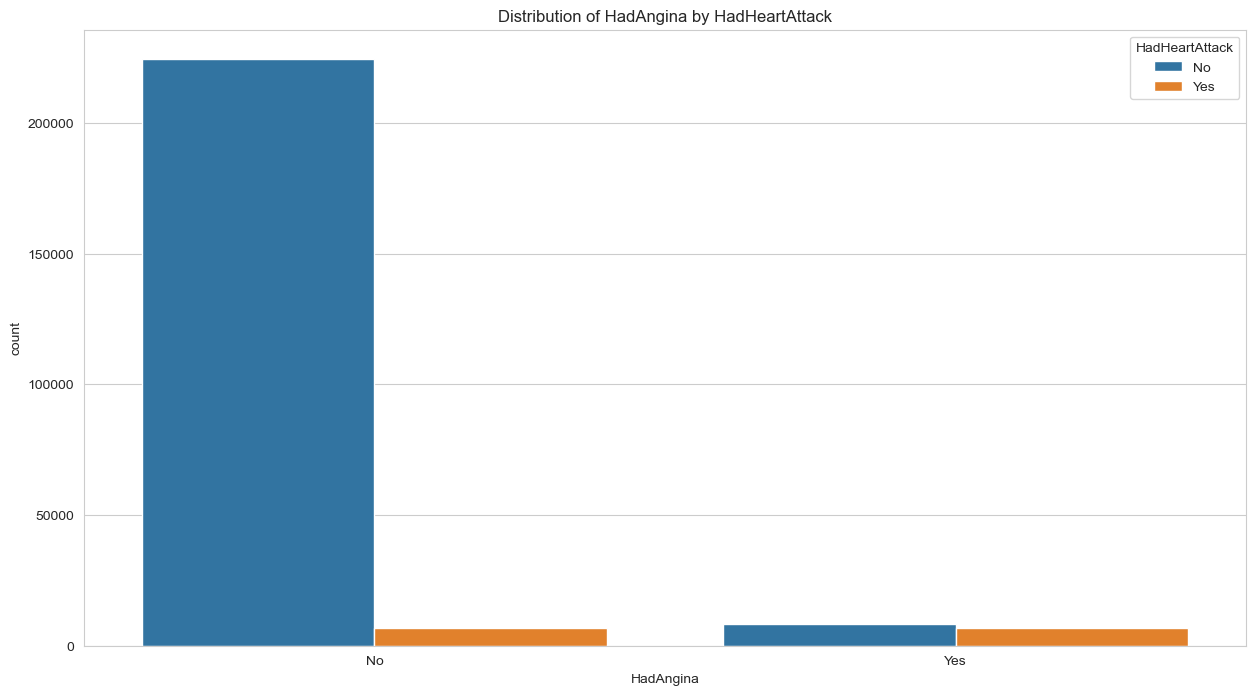

HadHeartAttack      No    Yes
HadStroke                    
No              224985  10917
Yes               7593   2518
Chi-Squared Test for HadStroke and HadHeartAttack
Chi2 value = 7716.361887180489, p-value = 0.0



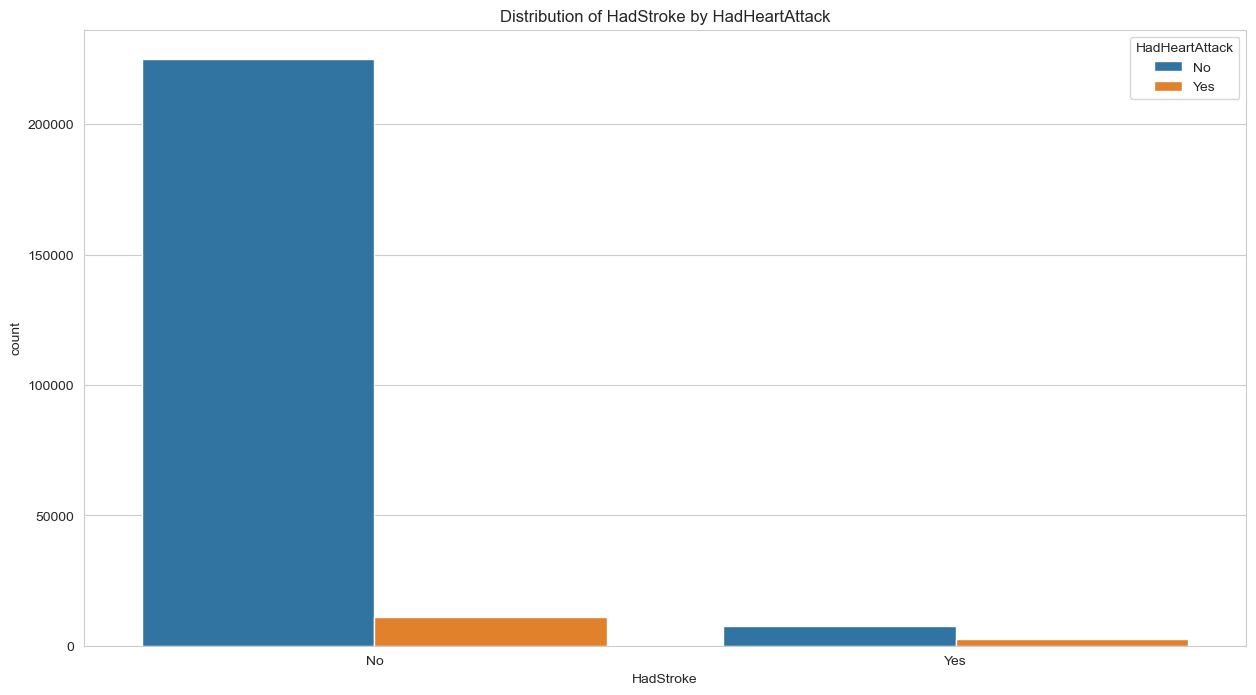

HadHeartAttack      No    Yes
HadAsthma                    
No              198518  10968
Yes              34060   2467
Chi-Squared Test for HadAsthma and HadHeartAttack
Chi2 value = 138.57317541492714, p-value = 5.460574633393451e-32



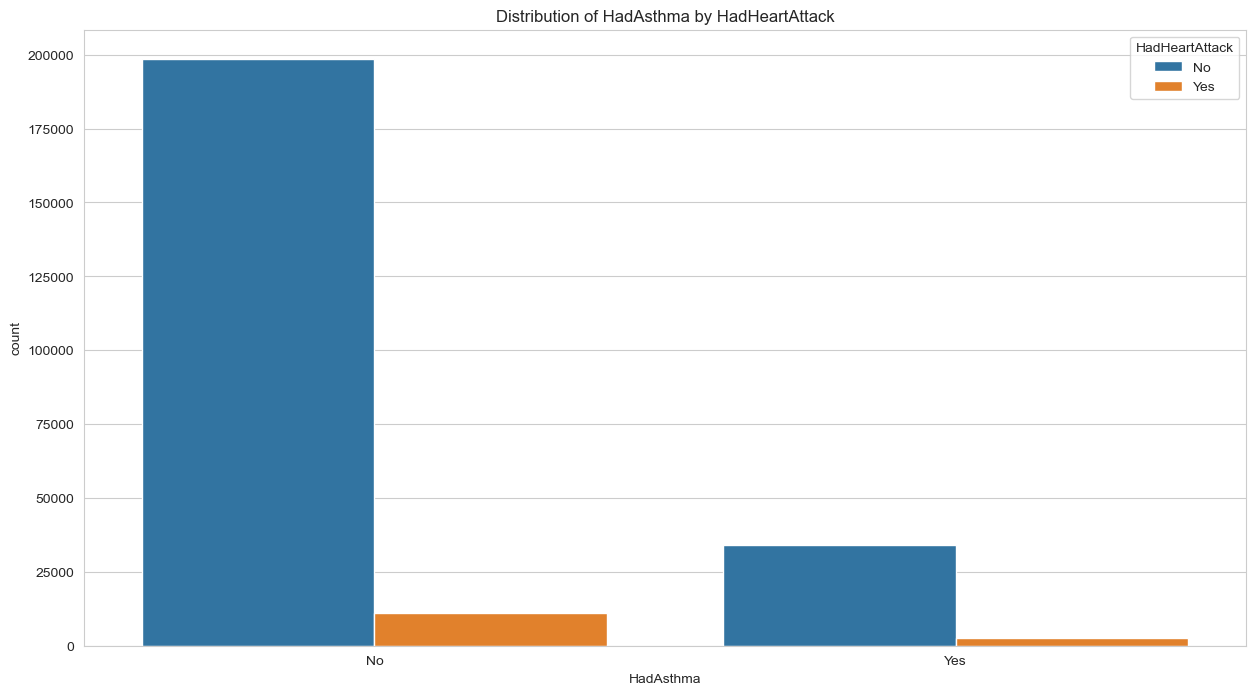

HadHeartAttack      No    Yes
HadSkinCancer                
No              213479  11515
Yes              19099   1920
Chi-Squared Test for HadSkinCancer and HadHeartAttack
Chi2 value = 599.9377487258555, p-value = 1.7271862867830458e-132



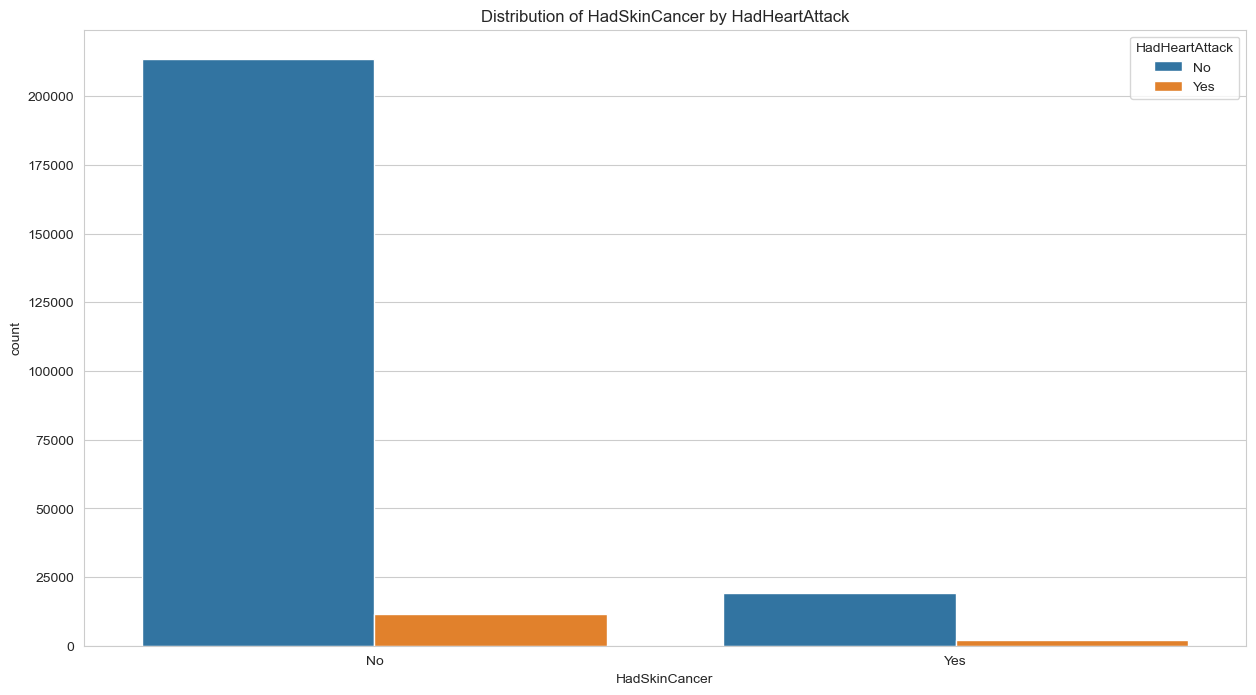

HadHeartAttack      No    Yes
HadCOPD                      
No              216609  10410
Yes              15969   3025
Chi-Squared Test for HadCOPD and HadHeartAttack
Chi2 value = 4363.963228084566, p-value = 0.0



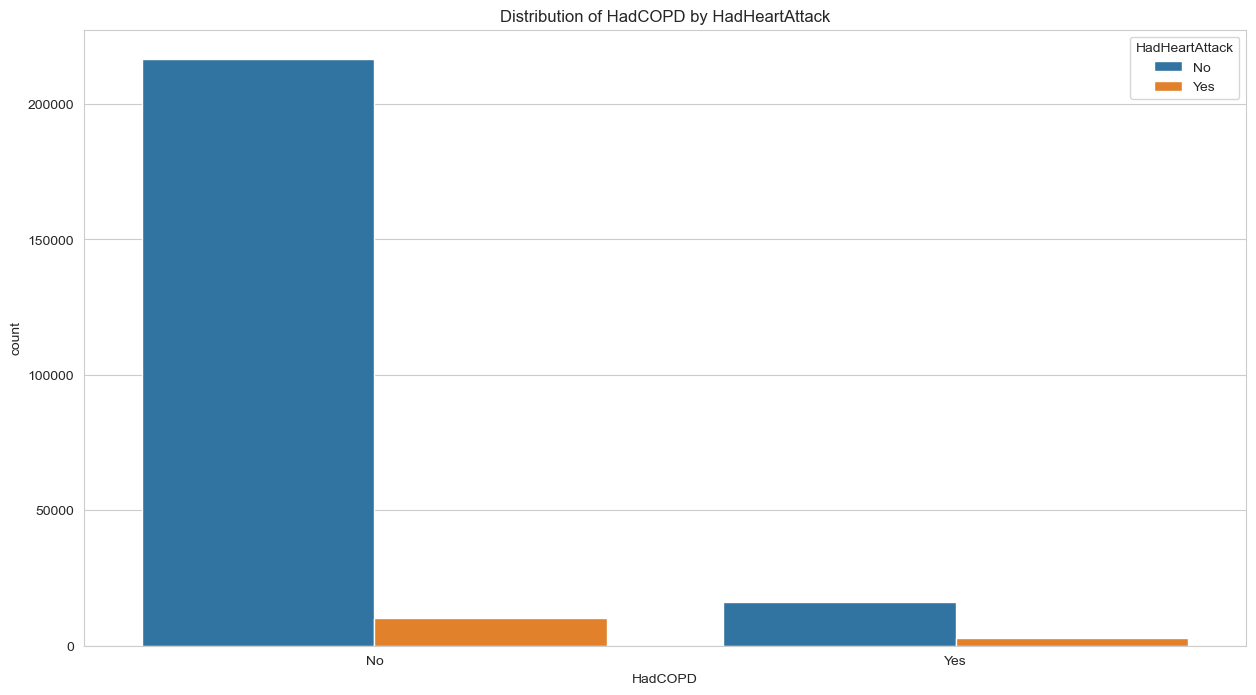

HadHeartAttack             No    Yes
HadDepressiveDisorder               
No                     185258  10135
Yes                     47320   3300
Chi-Squared Test for HadDepressiveDisorder and HadHeartAttack
Chi2 value = 137.94235523398163, p-value = 7.502329516886957e-32



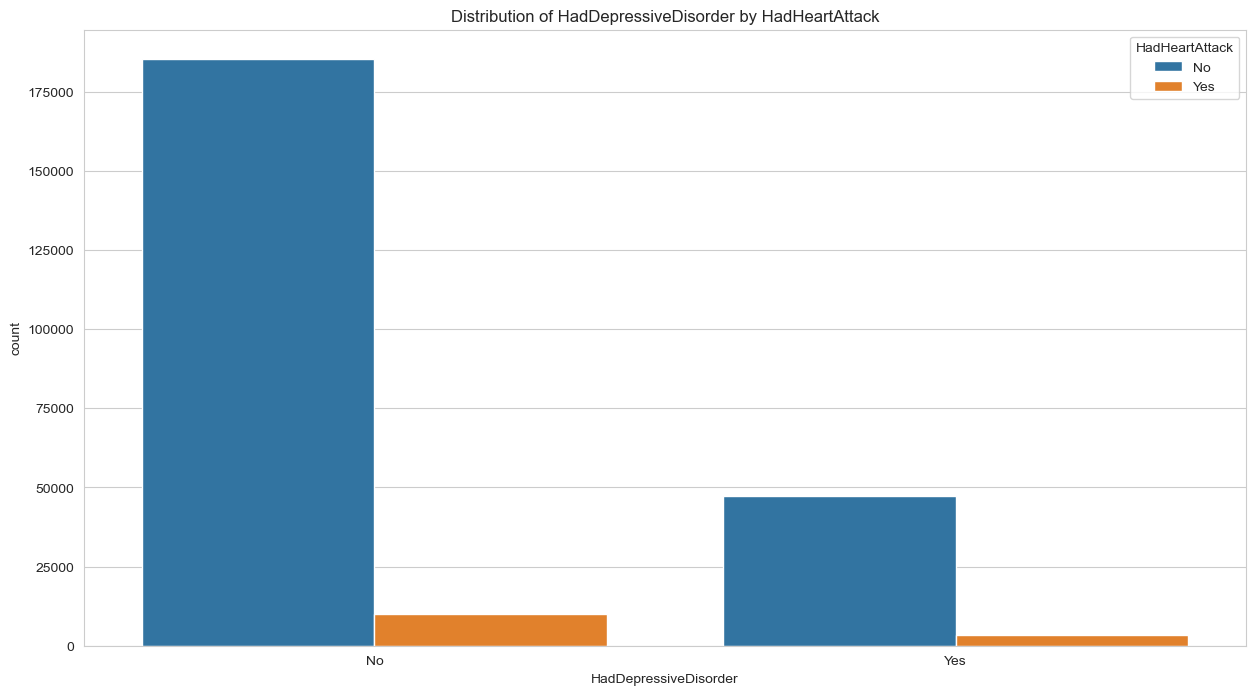

HadHeartAttack        No    Yes
HadKidneyDisease               
No                223189  11540
Yes                 9389   1895
Chi-Squared Test for HadKidneyDisease and HadHeartAttack
Chi2 value = 2939.5670891414943, p-value = 0.0



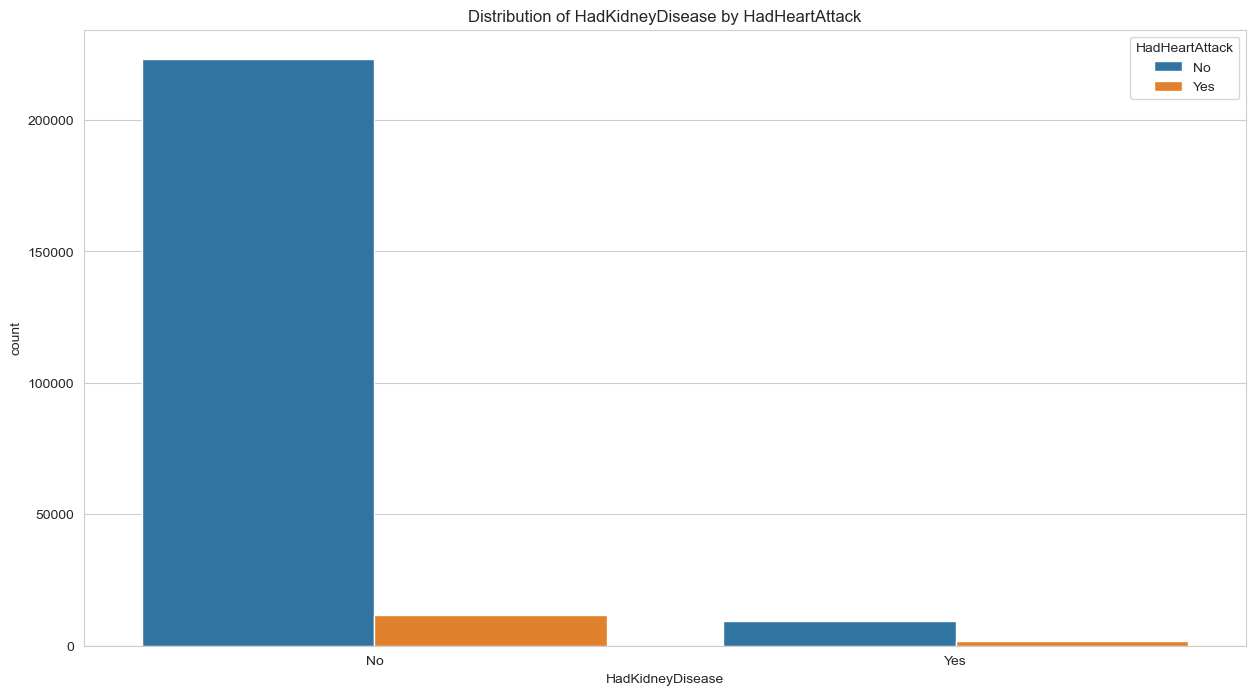

HadHeartAttack      No   Yes
HadArthritis                
No              155462  5670
Yes              77116  7765
Chi-Squared Test for HadArthritis and HadHeartAttack
Chi2 value = 3411.190093972503, p-value = 0.0



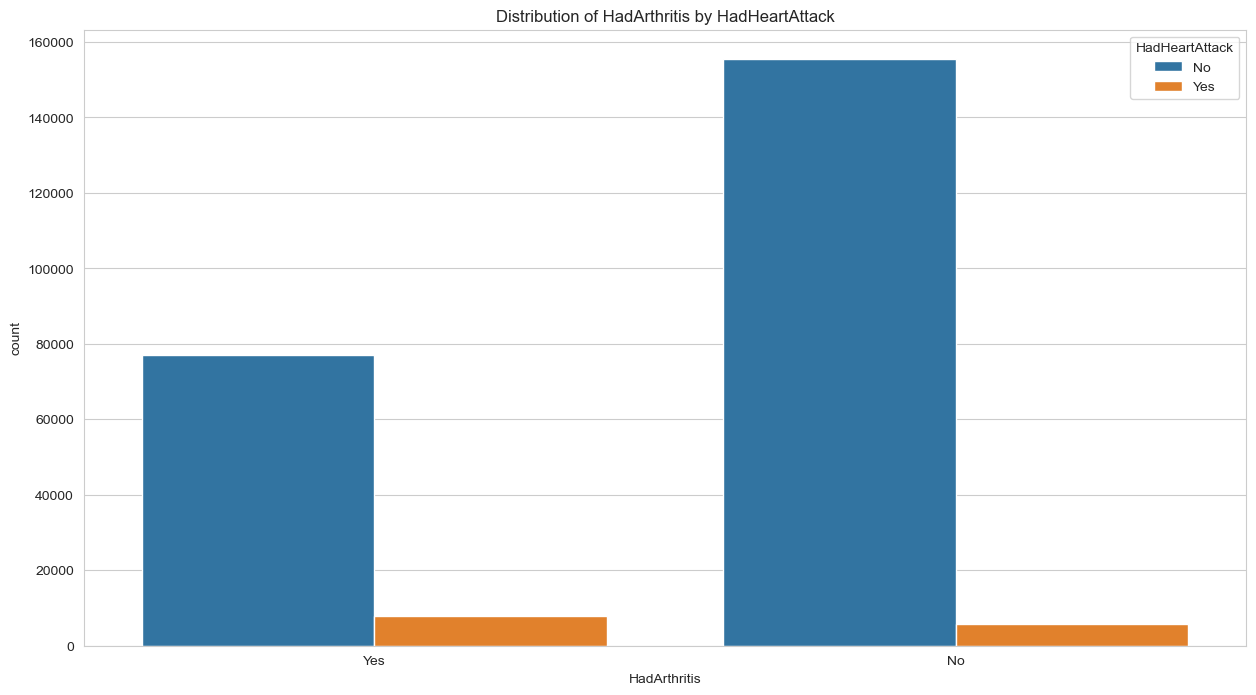

HadHeartAttack                               No   Yes
HadDiabetes                                          
No                                       196494  8333
No, pre-diabetes or borderline diabetes    5000   392
Yes                                       29157  4654
Yes, but only during pregnancy (female)    1927    56
Chi-Squared Test for HadDiabetes and HadHeartAttack
Chi2 value = 5345.9912570977585, p-value = 0.0



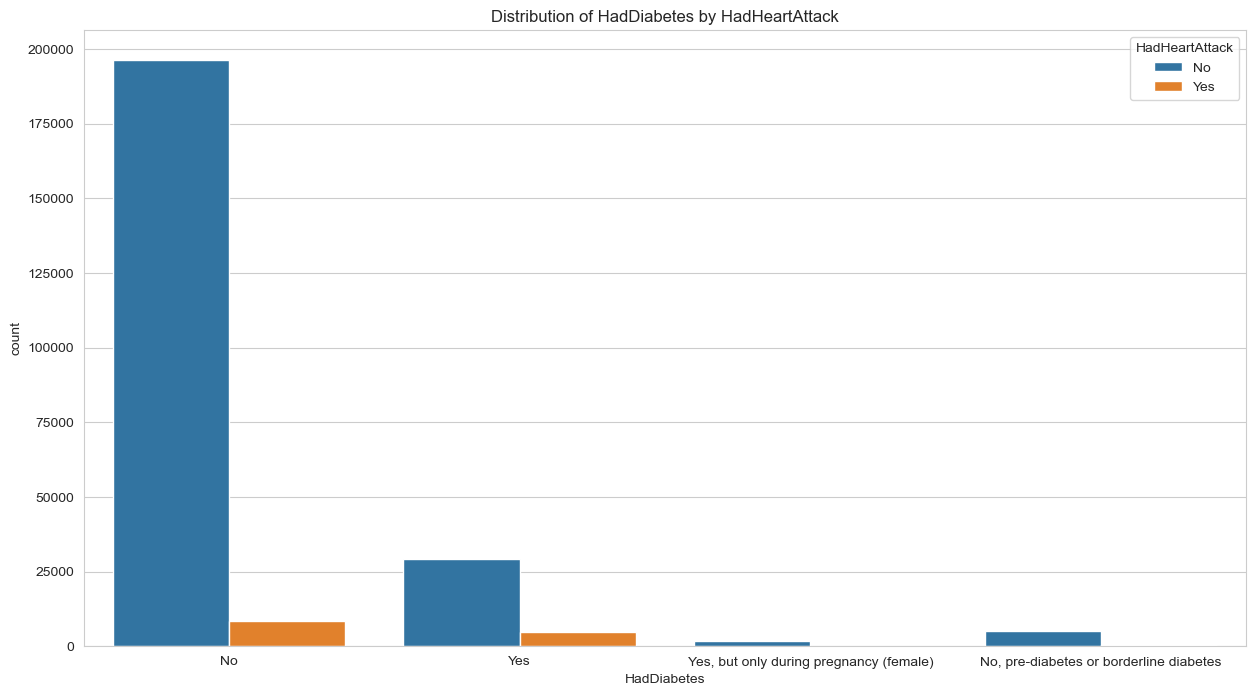

HadHeartAttack           No    Yes
DeafOrHardOfHearing               
No                   214221  10760
Yes                   18357   2675
Chi-Squared Test for DeafOrHardOfHearing and HadHeartAttack
Chi2 value = 2344.8042006382593, p-value = 0.0



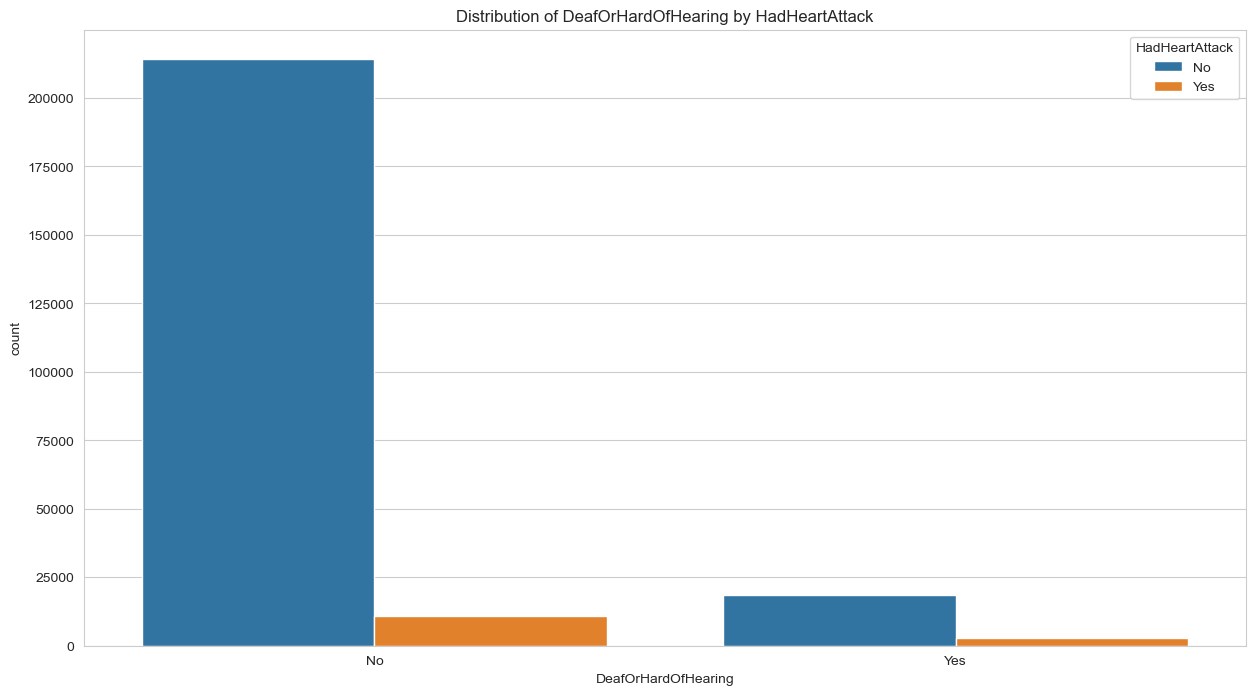

HadHeartAttack               No    Yes
BlindOrVisionDifficulty               
No                       221906  11881
Yes                       10672   1554
Chi-Squared Test for BlindOrVisionDifficulty and HadHeartAttack
Chi2 value = 1308.1593754891833, p-value = 1.9058085152167356e-286



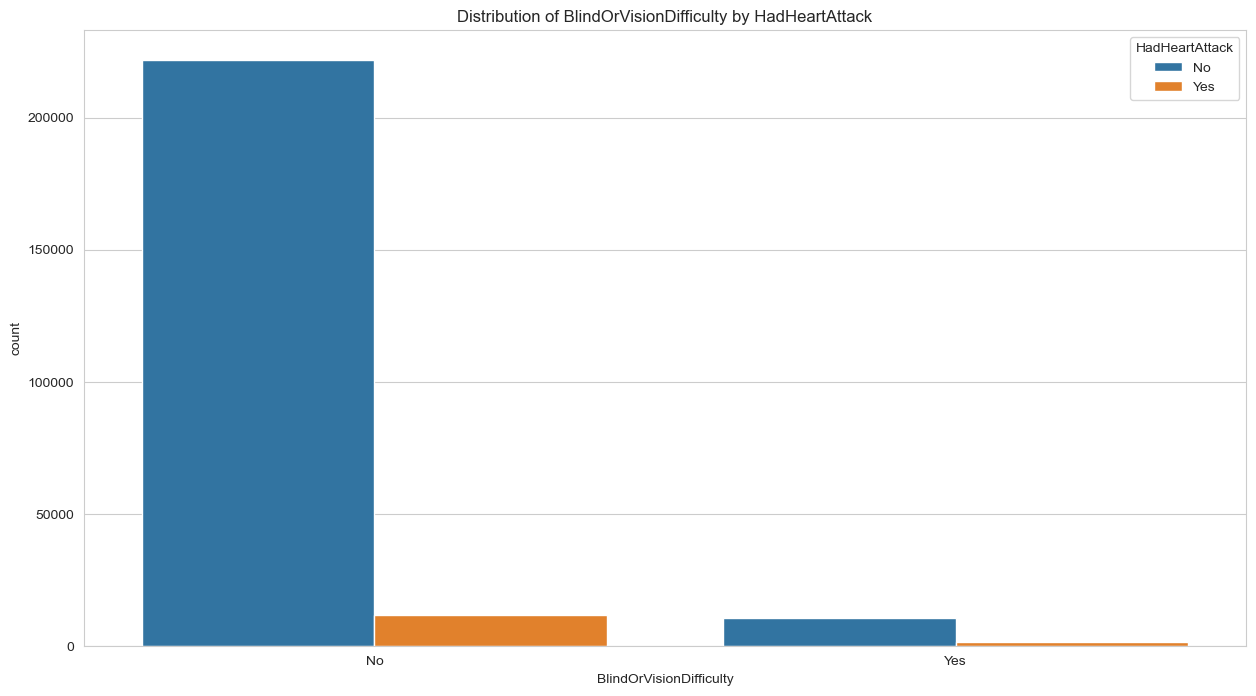

HadHeartAttack               No    Yes
DifficultyConcentrating               
No                       208681  11112
Yes                       23897   2323
Chi-Squared Test for DifficultyConcentrating and HadHeartAttack
Chi2 value = 655.8249785059869, p-value = 1.2086533205176142e-144



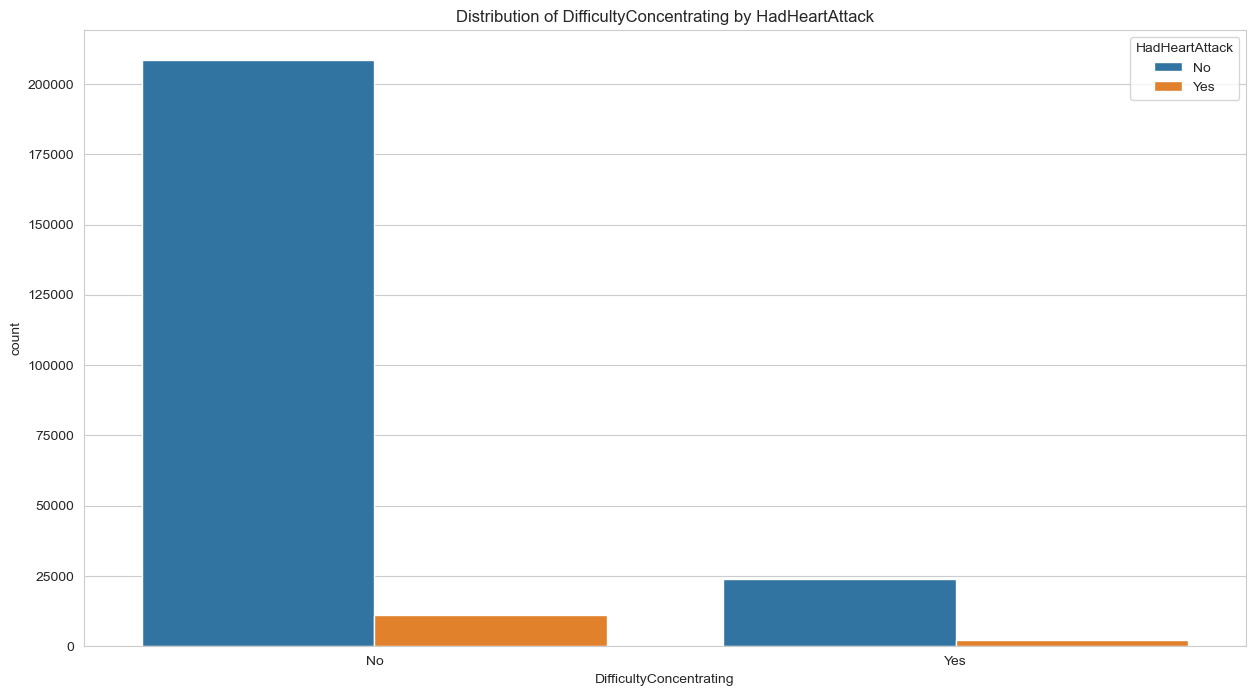

HadHeartAttack         No   Yes
DifficultyWalking              
No                 201641  8304
Yes                 30937  5131
Chi-Squared Test for DifficultyWalking and HadHeartAttack
Chi2 value = 6286.838781453804, p-value = 0.0



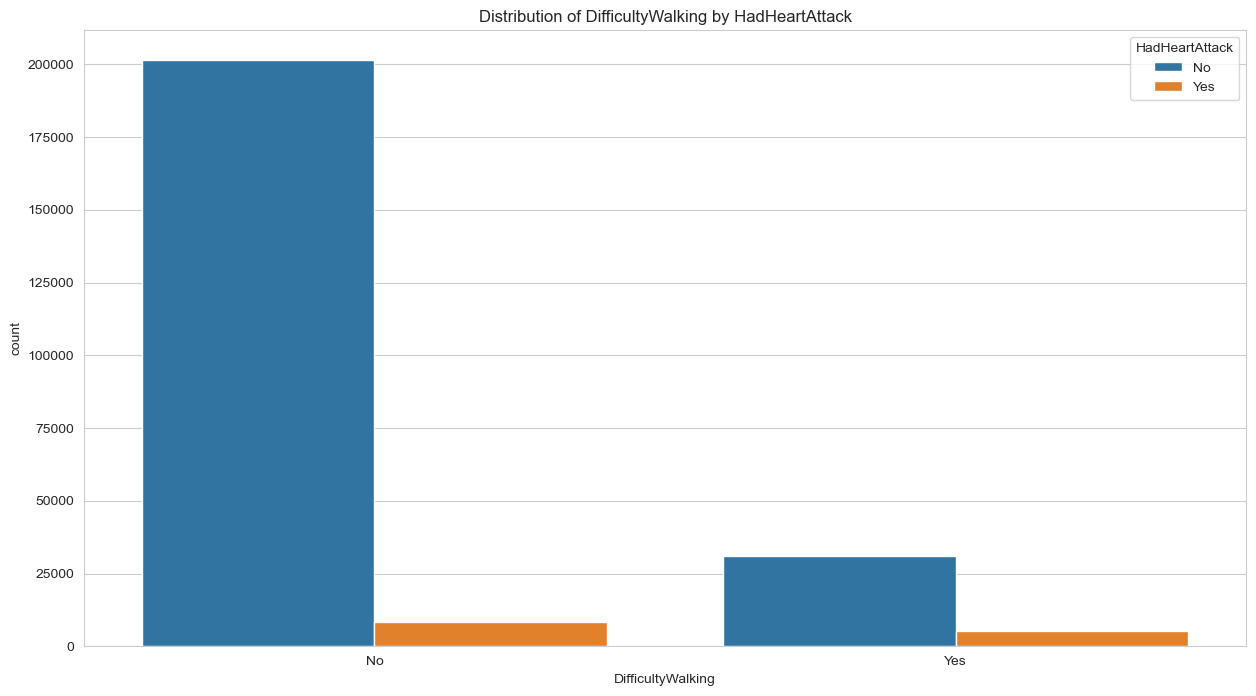

HadHeartAttack                 No    Yes
DifficultyDressingBathing               
No                         225534  12139
Yes                          7044   1296
Chi-Squared Test for DifficultyDressingBathing and HadHeartAttack
Chi2 value = 1696.394540678655, p-value = 0.0



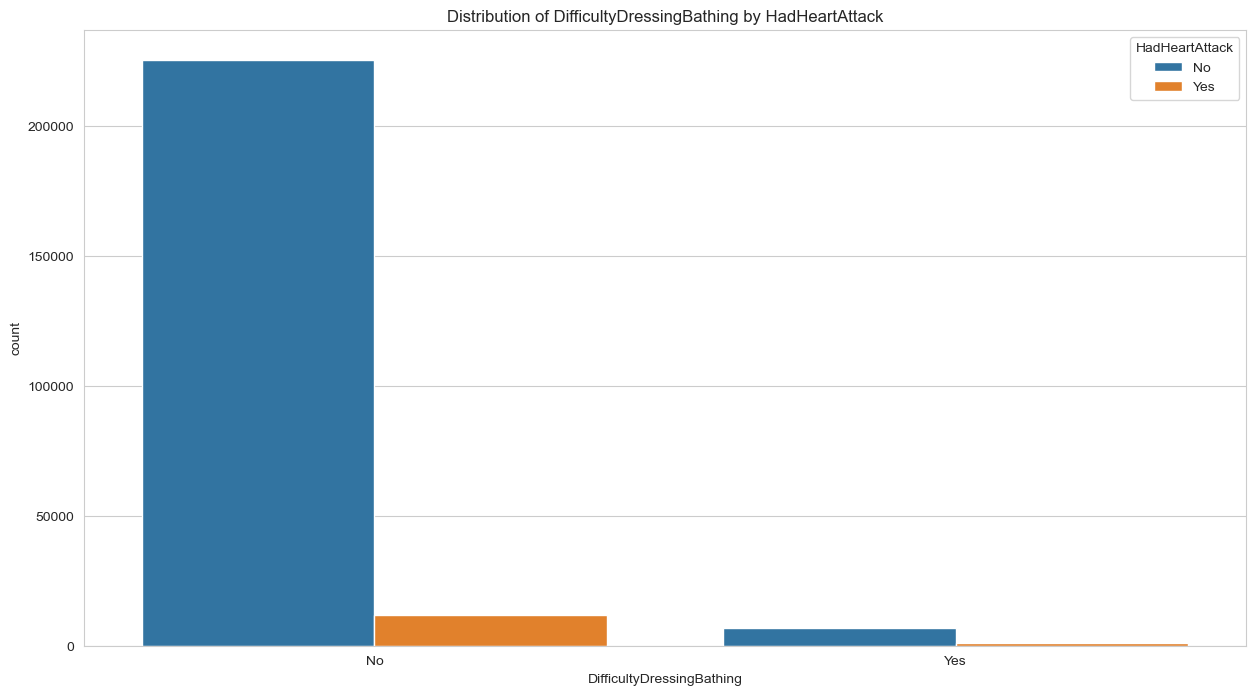

HadHeartAttack         No    Yes
DifficultyErrands               
No                 218336  11293
Yes                 14242   2142
Chi-Squared Test for DifficultyErrands and HadHeartAttack
Chi2 value = 1968.7158617259954, p-value = 0.0



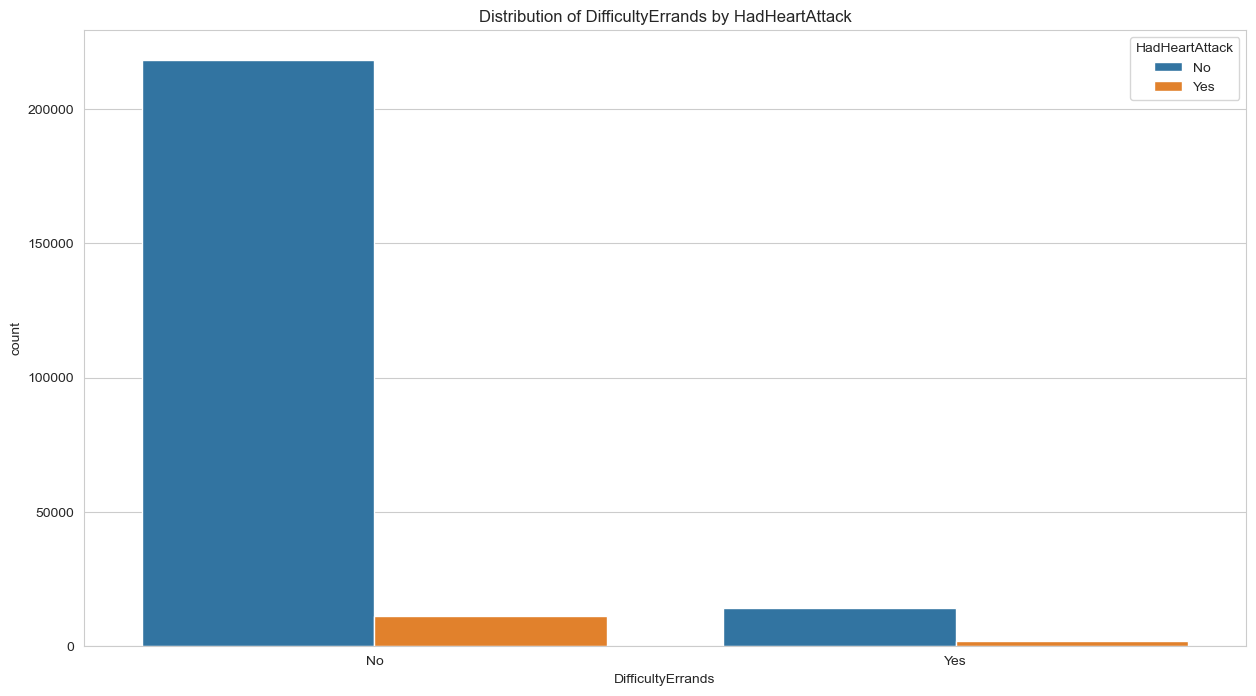

HadHeartAttack                             No   Yes
SmokerStatus                                       
Current smoker - now smokes every day   19858  1801
Current smoker - now smokes some days    7546   553
Former smoker                           62914  5610
Never smoked                           142260  5471
Chi-Squared Test for SmokerStatus and HadHeartAttack
Chi2 value = 2241.293874288016, p-value = 0.0



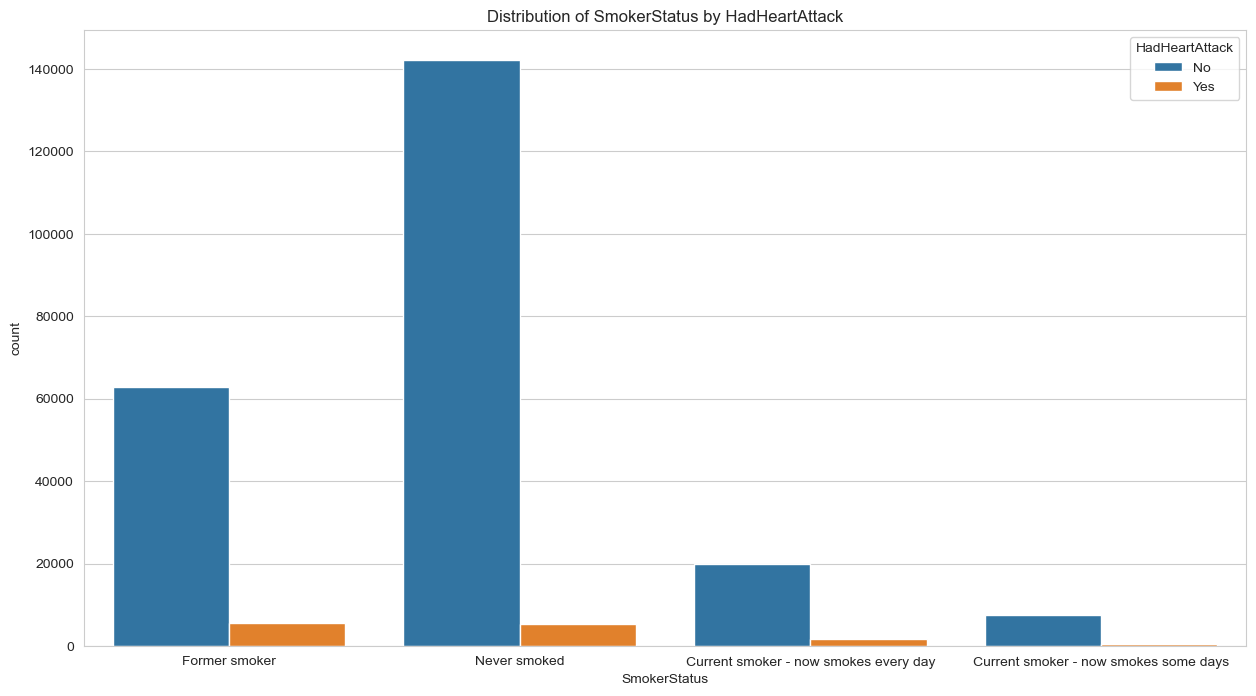

HadHeartAttack                                 No    Yes
ECigaretteUsage                                         
Never used e-cigarettes in my entire life  179547  10572
Not at all (right now)                      40846   2435
Use them every day                           5778    177
Use them some days                           6407    251
Chi-Squared Test for ECigaretteUsage and HadHeartAttack
Chi2 value = 114.26515381908608, p-value = 1.3252144336233886e-24



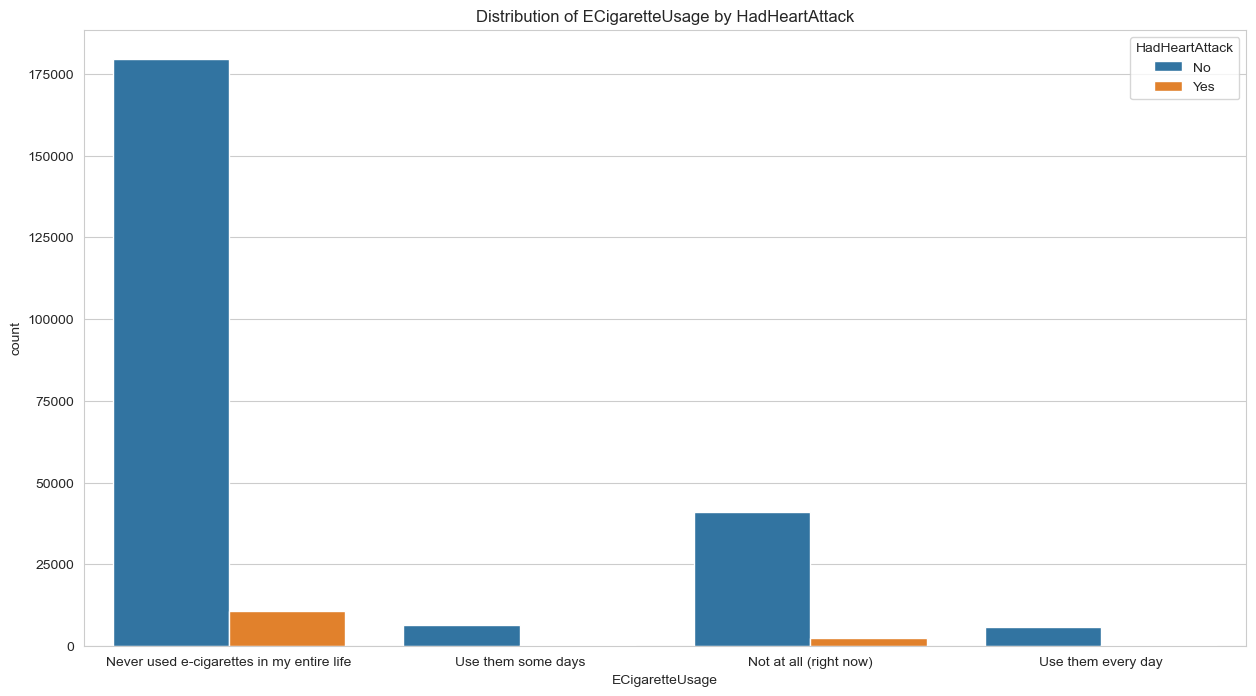

HadHeartAttack      No    Yes
ChestScan                    
No              138707   3111
Yes              93871  10324
Chi-Squared Test for ChestScan and HadHeartAttack
Chi2 value = 6922.660386789881, p-value = 0.0



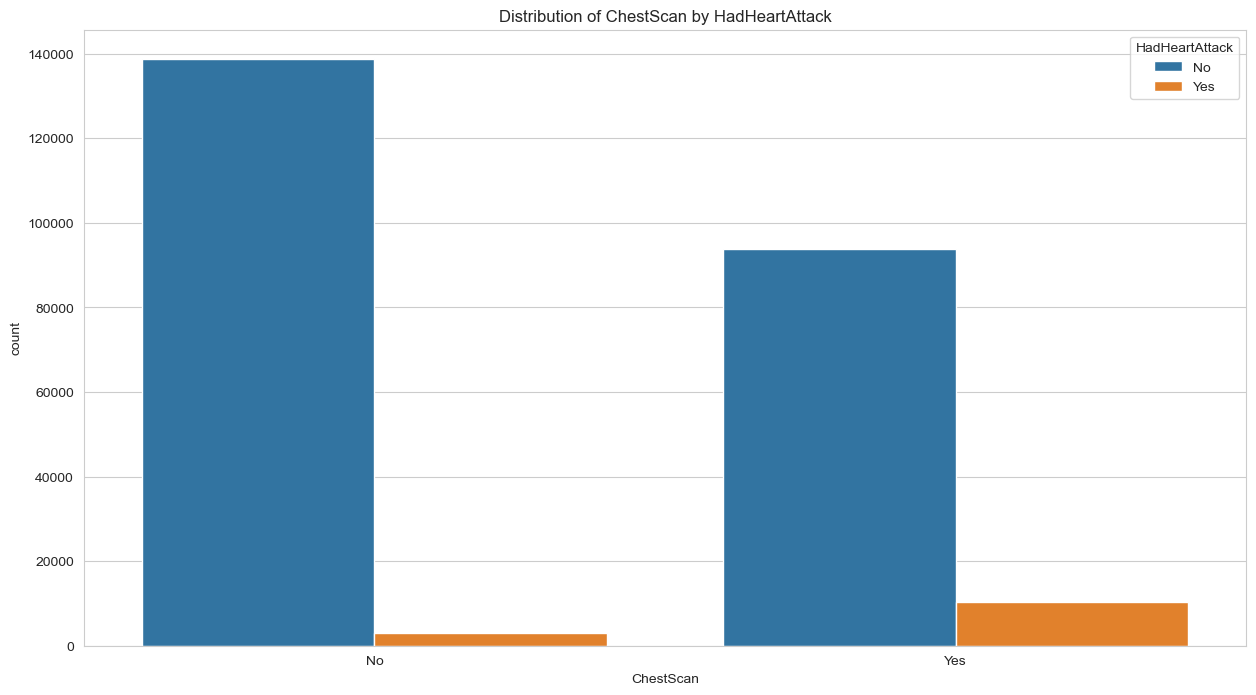

HadHeartAttack                     No    Yes
RaceEthnicityCategory                       
Black only, Non-Hispanic        18441    889
Hispanic                        21711    859
Multiracial, Non-Hispanic        5241    340
Other race only, Non-Hispanic   11614    591
White only, Non-Hispanic       175571  10756
Chi-Squared Test for RaceEthnicityCategory and HadHeartAttack
Chi2 value = 195.9712006643616, p-value = 2.760364866338809e-41



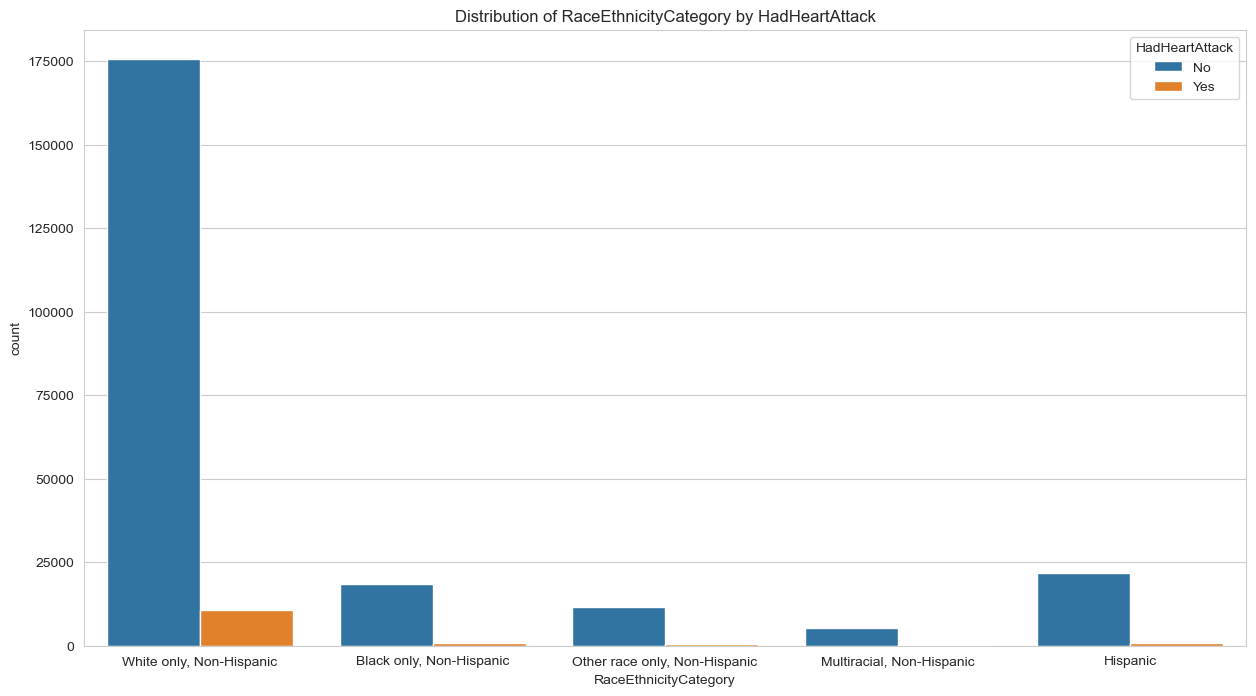

HadHeartAttack      No   Yes
AgeCategory                 
Age 18 to 24     13072    50
Age 25 to 29     11062    47
Age 30 to 34     13256    90
Age 35 to 39     15458   156
Age 40 to 44     16745   228
Age 45 to 49     16333   420
Age 50 to 54     19209   703
Age 55 to 59     21112  1112
Age 60 to 64     25144  1575
Age 65 to 69     26400  2155
Age 70 to 74     23329  2408
Age 75 to 79     16068  2065
Age 80 or older  15390  2426
Chi-Squared Test for AgeCategory and HadHeartAttack
Chi2 value = 7925.704390290559, p-value = 0.0



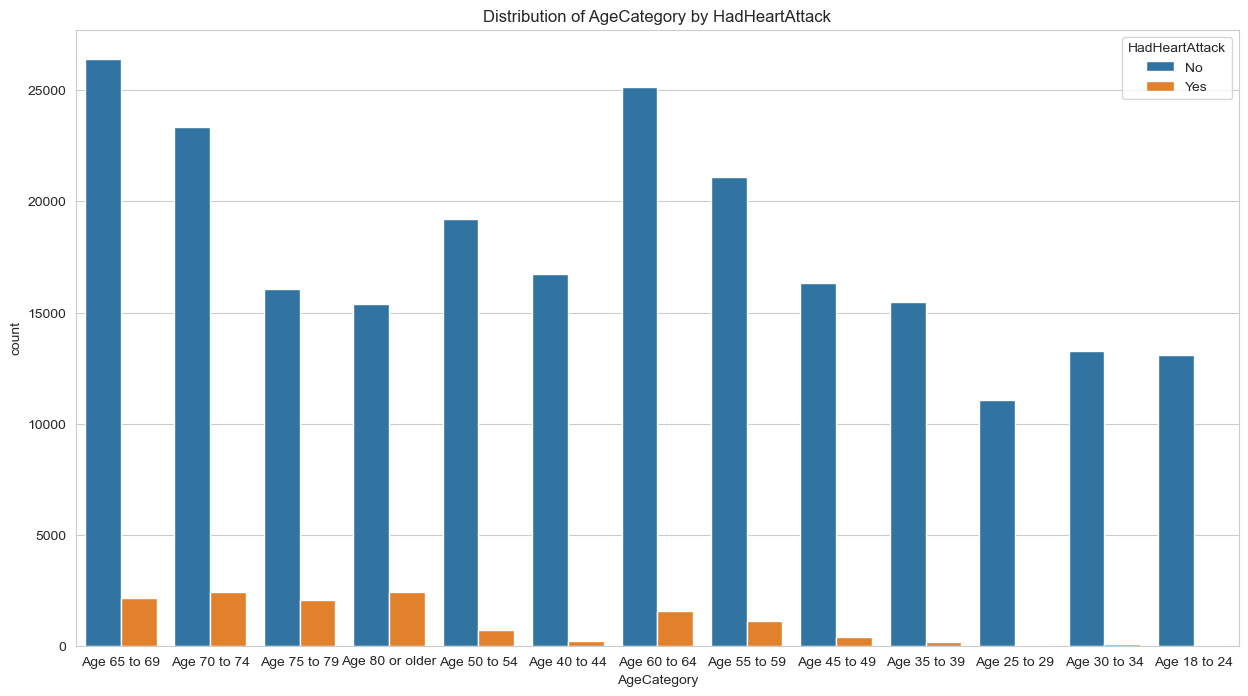

HadHeartAttack       No   Yes
AlcoholDrinkers              
No               102605  8109
Yes              129973  5326
Chi-Squared Test for AlcoholDrinkers and HadHeartAttack
Chi2 value = 1352.9336428746574, p-value = 3.5495529688639013e-296



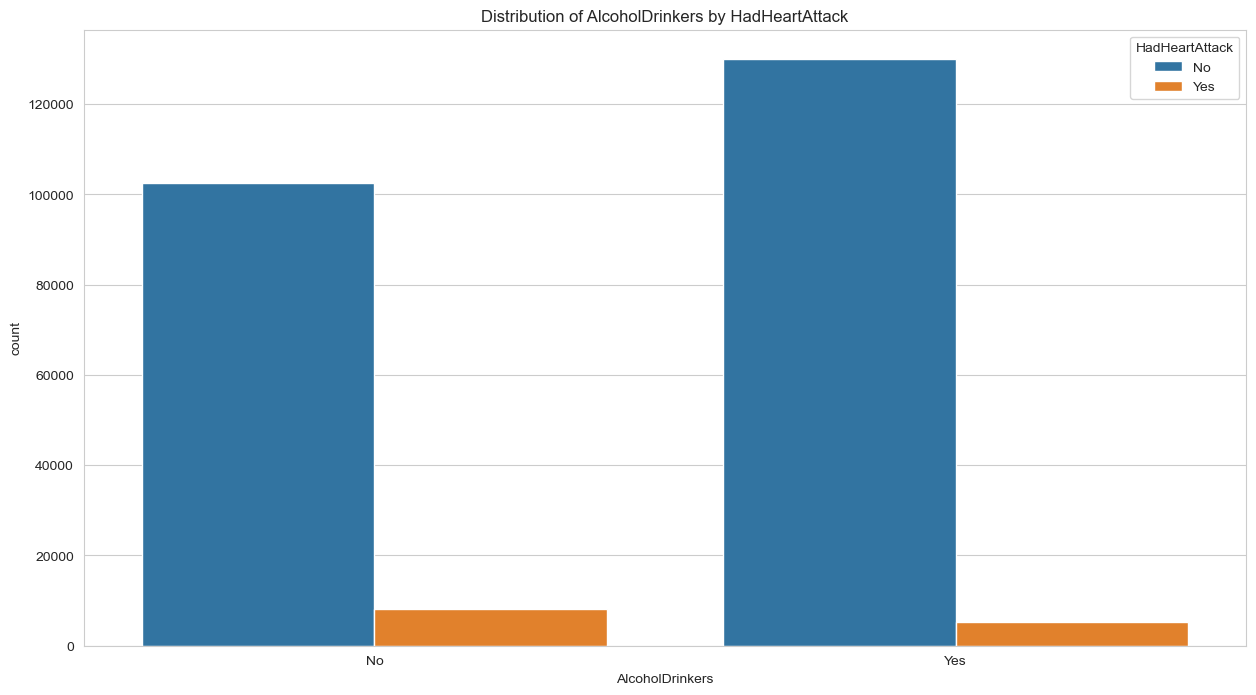

HadHeartAttack      No   Yes
HIVTesting                  
No              152306  9207
Yes              80272  4228
Chi-Squared Test for HIVTesting and HadHeartAttack
Chi2 value = 52.054385349053376, p-value = 5.398452954756739e-13



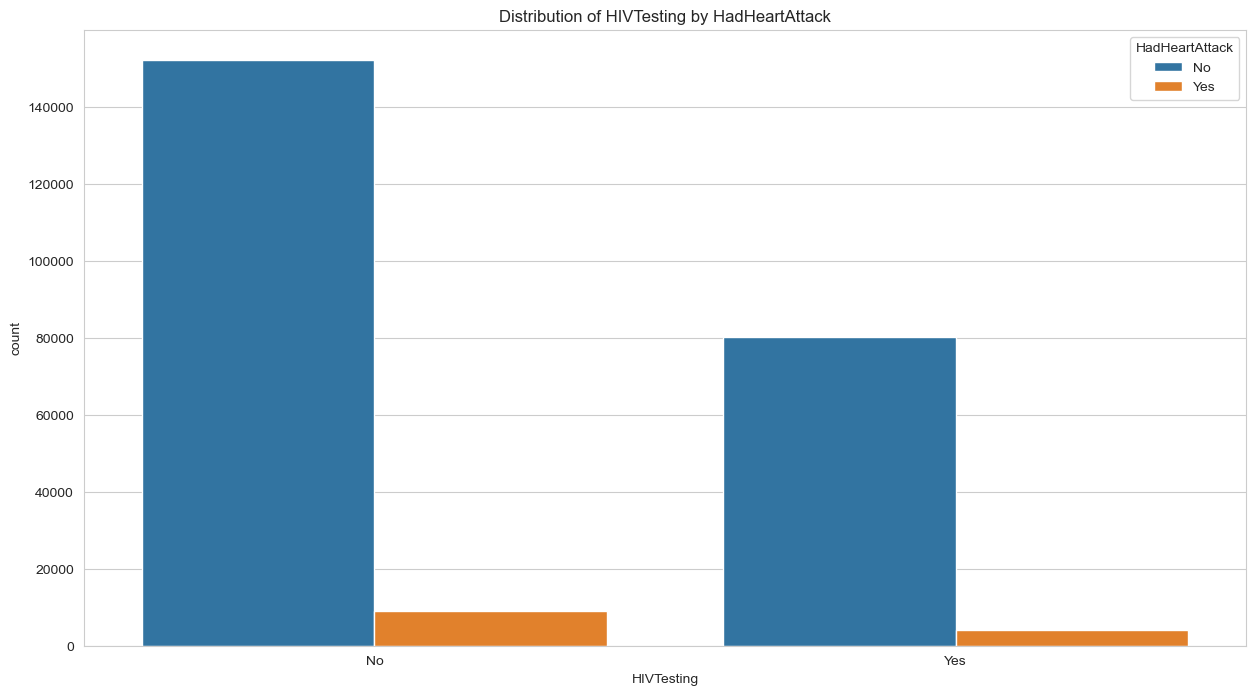

HadHeartAttack      No   Yes
FluVaxLast12                
No              109816  5009
Yes             122762  8426
Chi-Squared Test for FluVaxLast12 and HadHeartAttack
Chi2 value = 503.1594851068325, p-value = 1.952245327911882e-111



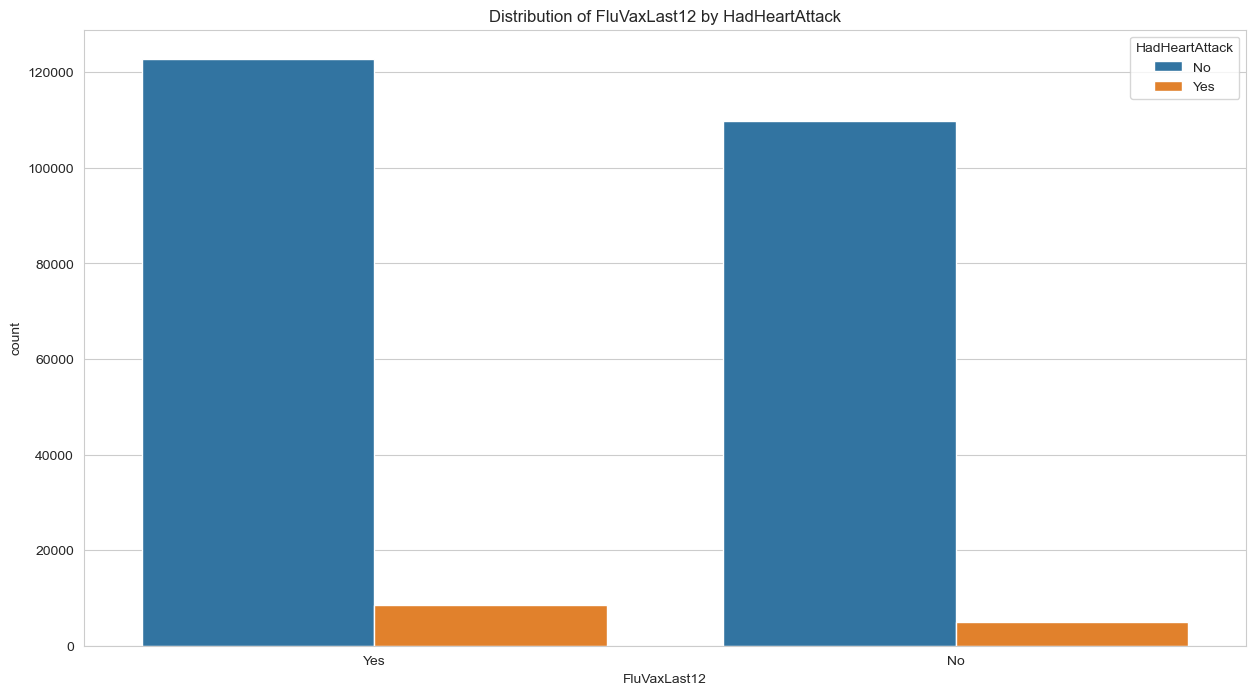

HadHeartAttack      No   Yes
PneumoVaxEver               
No              141441  4687
Yes              91137  8748
Chi-Squared Test for PneumoVaxEver and HadHeartAttack
Chi2 value = 3539.4434942388366, p-value = 0.0



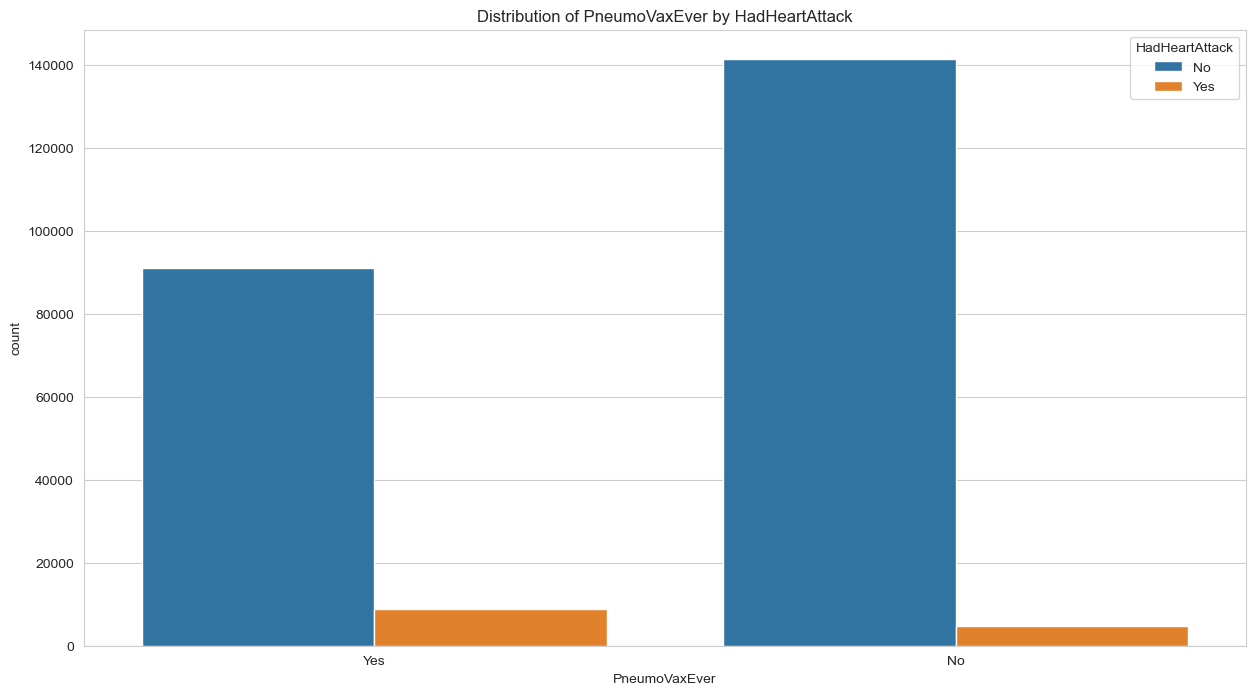

HadHeartAttack                                         No   Yes
TetanusLast10Tdap                                              
No, did not receive any tetanus shot in the pas...  76966  4777
Yes, received Tdap                                  67463  2819
Yes, received tetanus shot but not sure what type   69513  4605
Yes, received tetanus shot, but not Tdap            18636  1234
Chi-Squared Test for TetanusLast10Tdap and HadHeartAttack
Chi2 value = 412.2456977489708, p-value = 4.9266526646514085e-89



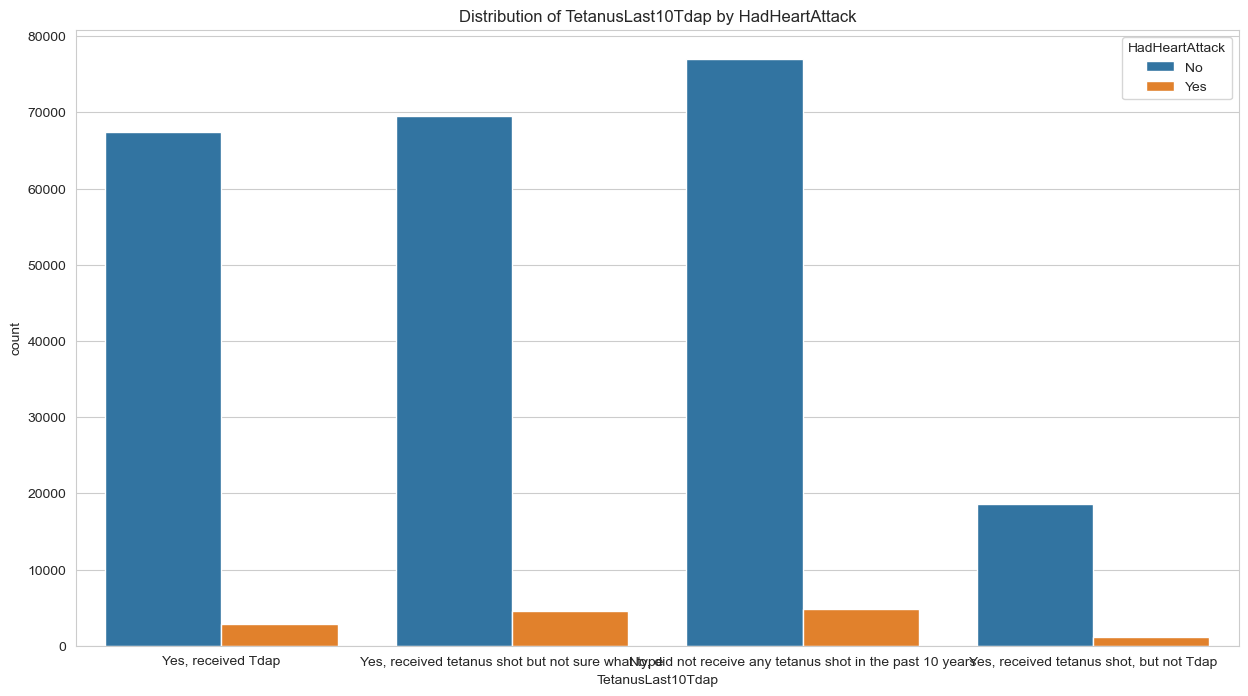

HadHeartAttack        No    Yes
HighRiskLastYear               
No                222340  13097
Yes                10238    338
Chi-Squared Test for HighRiskLastYear and HadHeartAttack
Chi2 value = 109.3716134286175, p-value = 1.3454258258489073e-25



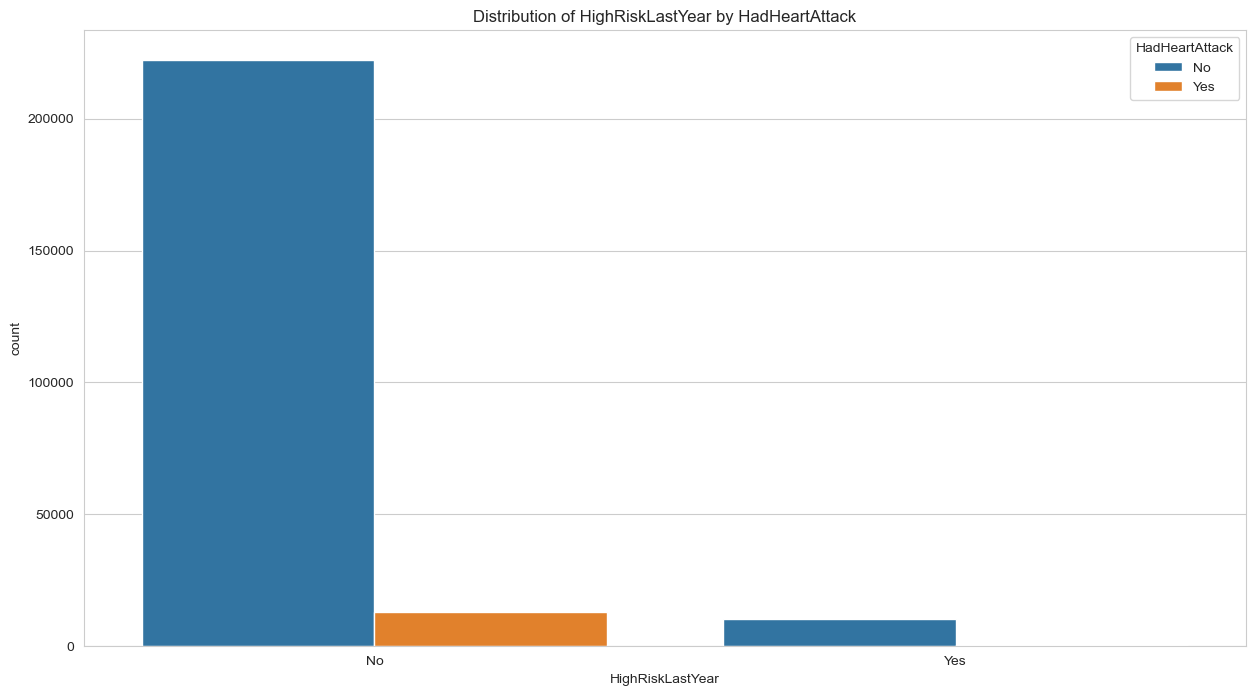

HadHeartAttack                                          No   Yes
CovidPos                                                        
No                                                  157521  9776
Tested positive using home test without a healt...    8158   234
Yes                                                  66899  3425
Chi-Squared Test for CovidPos and HadHeartAttack
Chi2 value = 211.03994555450967, p-value = 1.490246437343113e-46



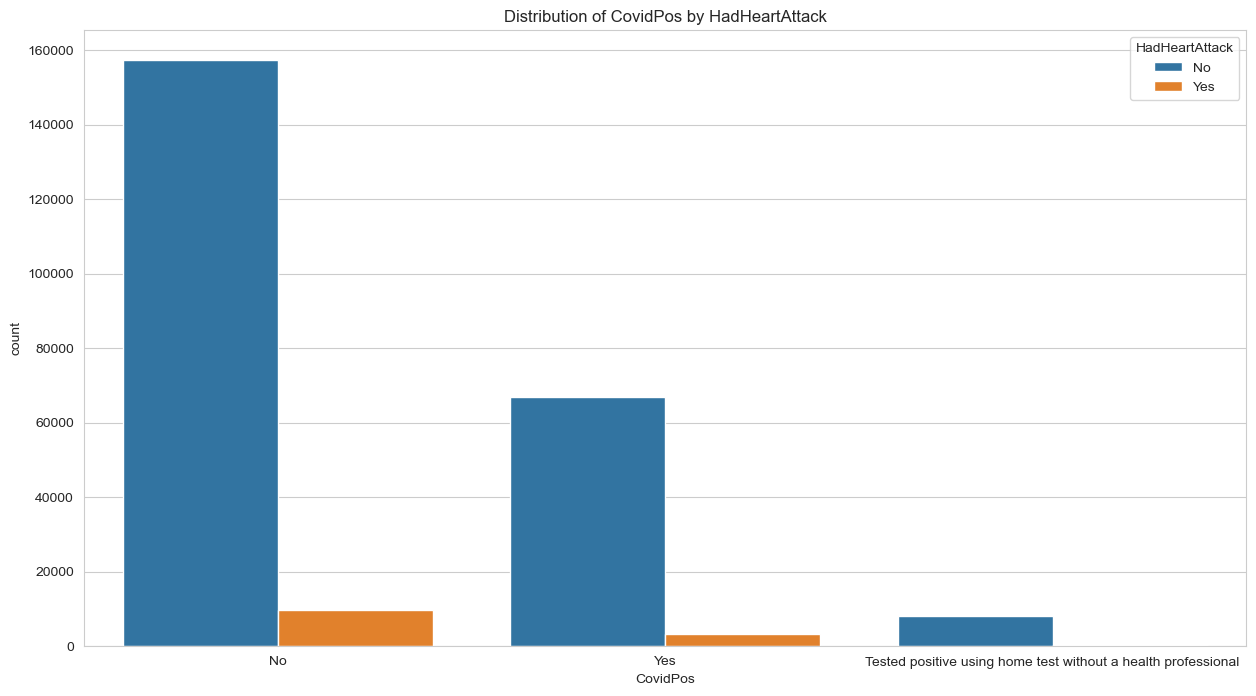

In [47]:
# Dataframe to store result of Chi2 test
results_df_cat = pd.DataFrame(columns=['Feature', 'Chi2', 'P-Value'])

# Copy to keep the original dataframe
cat_df = df.copy()
cat_df["HadHeartAttack"] = cat_df["HadHeartAttack"].astype('category')

# For each categorical ver perform Chi2 test
# Print results, create bar plot
for var in categorical_vars:
  cat_df[var] = cat_df[var].astype('category')
  contingency_table = pd.crosstab(cat_df[var], cat_df["HadHeartAttack"])
  chi2, p, _, _ = chi2_contingency(contingency_table)
  print(contingency_table)
  print(f"Chi-Squared Test for {var} and {target}")
  print(f"Chi2 value = {chi2}, p-value = {p}\n")
  # Add the results to the DataFrame
  new_row = {'Feature': var, 'Chi2': chi2, 'P-Value': p}
  results_df_cat = pd.concat([results_df_cat, pd.DataFrame(new_row, index=[0])], ignore_index=True)
  # Bar Plots
  plt.figure(figsize=(15, 8))
  sns.countplot(data=df, x=var, hue=target)
  plt.title(f"Distribution of {var} by {target}")
  plt.show()


In [48]:
# Perform t-tests for numerical data
results_df_nums = pd.DataFrame(columns=['Feature', 'Statistic', 'P-Value'])

for var in numerical_vars:
  # Statistical Test (e.g., t-test) for significance
  for category in df[target].unique():
    group1 = df[df[target] == category][var]
    group2 = df[df[target] != category][var]

  stat, p = ttest_ind(group1, group2)

  # Add the results to the DataFrame
  new_row = {'Feature': var, 'Statistic': stat, 'P-Value': p}
  results_df_nums = pd.concat([results_df_nums, pd.DataFrame(new_row, index=[0])], ignore_index=True)


In [49]:
# Sort the DataFrame by p-values in ascending order and then by chi2 values in descending order
results_df_cat = results_df_cat.sort_values(by=['P-Value', 'Chi2'], ascending=[True, False])

# Display the sorted DataFrame
display(results_df_cat)

,Feature,Chi2,P-Value
4,HadAngina,48906.220749,0.000000e+00
1,GeneralHealth,9893.539444,0.000000e+00
23,AgeCategory,7925.704390,0.000000e+00
5,HadStroke,7716.361887,0.000000e+00
3,RemovedTeeth,6996.544849,0.000000e+00
21,ChestScan,6922.660387,0.000000e+00
16,DifficultyWalking,6286.838781,0.000000e+00
12,HadDiabetes,5345.991257,0.000000e+00
8,HadCOPD,4363.963228,0.000000e+00
27,PneumoVaxEver,3539.443494,0.000000e+00


In [50]:
# Sort the DataFrame by p-values in ascending order
results_df_nums = results_df_nums.sort_values(by='P-Value', ascending=True)

# Display the sorted DataFrame
display(results_df_nums)

,Feature,Statistic,P-Value
0,PhysicalHealthDays,66.773602,0.000000e+00
4,WeightInKilograms,19.076335,4.546370e-81
1,MentalHealthDays,12.844421,9.506448e-38
3,HeightInMeters,11.440249,2.678179e-30
2,SleepHours,1.802562,7.145820e-02


### Null Hypothesis Testing

We're intersted to test the following $null$ hypothesis:

$H_0$: General health and Smoker status don't have effect on the possibility of a heart attack

$H_A$: General health and Smoker have effect on the possibility of a heart attack

In [51]:
hypothesis_df = results_df_cat[results_df_cat['Feature'].isin(['GeneralHealth', 'SmokerStatus'])]

# Define the significance level (alpha)
alpha = 0.05  # You can choose a different alpha value if needed

# Verify the null hypothesis for each feature
for index, row in hypothesis_df.iterrows():
    feature = row['Feature']
    chi2 = row['Chi2']
    p_value = row['P-Value']

    print(f"Feature: {feature}")
    print(f"Chi-Squared Value: {chi2}")
    print(f"P-Value: {p_value}")

    if p_value < alpha:
        print("Reject the null hypothesis (𝐻0)")
        print(f"{feature} has an effect on the possibility of a heart attack.")
    else:
        print("Fail to reject the null hypothesis (𝐻0)")
        print(f"{feature} does not have an effect on the possibility of a heart attack.")

    print("\n")

Feature: GeneralHealth
Chi-Squared Value: 9893.539444125969
P-Value: 0.0
Reject the null hypothesis (𝐻0)
GeneralHealth has an effect on the possibility of a heart attack.


Feature: SmokerStatus
Chi-Squared Value: 2241.293874288016
P-Value: 0.0
Reject the null hypothesis (𝐻0)
SmokerStatus has an effect on the possibility of a heart attack.




### Conclusion

* We have complted chi square test and we able to reject the $null$ hypothesis.


## Model Selection



In [52]:
# TESTING FOR MULTICOLLINEARITY
# Add a constant term to the predictor variables
X = add_constant(df[['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours', 'HeightInMeters', 'WeightInKilograms']])

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

             Variable         VIF
0               const  304.683975
1  PhysicalHealthDays    1.115540
2    MentalHealthDays    1.123823
3          SleepHours    1.019942
4      HeightInMeters    1.306575
5   WeightInKilograms    1.311968


In [53]:
# HERE WE ADD DUMMIES TO THE CATEGORICAL VARIABLES
heart_df = pd.get_dummies(df, columns=categorical_includes_taget, drop_first=True, dtype='int32')
heart_df.head(5)

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,Sex_Male,GeneralHealth_Fair,GeneralHealth_Good,GeneralHealth_Poor,GeneralHealth_Very good,...,HIVTesting_Yes,FluVaxLast12_Yes,PneumoVaxEver_Yes,"TetanusLast10Tdap_Yes, received Tdap","TetanusLast10Tdap_Yes, received tetanus shot but not sure what type","TetanusLast10Tdap_Yes, received tetanus shot, but not Tdap",HighRiskLastYear_Yes,CovidPos_Tested positive using home test without a health professional,CovidPos_Yes,HadHeartAttack_Yes
0,4.0,0.0,9.0,1.60,71.67,0,0,0,0,1,...,0,1,1,1,0,0,0,0,0,0
1,0.0,0.0,6.0,1.78,95.25,1,0,0,0,1,...,0,1,1,0,1,0,0,0,0,0
2,0.0,0.0,8.0,1.85,108.86,1,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
3,5.0,0.0,9.0,1.70,90.72,0,1,0,0,0,...,0,1,1,0,0,0,0,0,1,0
4,3.0,15.0,5.0,1.55,79.38,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0


In [54]:
# REMOVE OUR DEPENDENT VARIABLE
target = 'HadHeartAttack_Yes'
X = heart_df.drop(target, axis=1)
y = heart_df[target]

Since, the dataset description suggested unbalanced data, we are going to perform model training:

* On the original data
* On the data with oversampling with $SMOTE$ (Synthetic Minority Oversampling Technique)
* On the data with undersampling

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# GENERATING THE OVERSAMPLE:
smote = SMOTE(random_state=42)
X_ovsampled, y_ovsampled = smote.fit_resample(X_train, y_train)

# GENERATING THE UNDERSAMPLE:
undersampler = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)

In [56]:
# LOGISTIC REGRESSION
def train_and_evaluate_logit(X_train, X_test, y_train, y_test, random_state=42):
    X_train_ = X_train.copy()
    X_test_ = X_test.copy()

    X_train_ = sm.add_constant(X_train_)
    X_test_ = sm.add_constant(X_test_)
    result = sm.Logit(y_train, X_train_).fit()

    y_pred = result.predict(X_test_)
    y_pred = np.where(y_pred > 0.5, 1, 0)

    report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    return (result, report_df)

In [57]:
# DECISION TREE MODEL
def train_and_evaluate_decision_tree(X_train, X_test, y_train, y_test, random_state=42):
    # Create and fit a DecisionTreeClassifier
    classifier = DecisionTreeClassifier(random_state=random_state)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    return (classifier, report_df)

In [58]:
# RESULTS FOR LOGISTIC REGRESSION WITH ORIGINAL DATA
result_log, report_df_log = train_and_evaluate_logit(X_train, X_test, y_train, y_test)
display(report_df_log)

Optimization terminated successfully.
         Current function value: 0.145333
         Iterations 10


,precision,recall,f1-score,support
0,0.958957,0.988616,0.973561,46558.00000
1,0.560166,0.255198,0.350649,2645.00000
accuracy,0.949190,0.949190,0.949190,0.94919
macro avg,0.759561,0.621907,0.662105,49203.00000
weighted avg,0.937519,0.949190,0.940075,49203.00000


In [59]:
# RESULTS FOR LOGISTIC REGRESSION WITH OVERSAMPLE WITH SMOTE
result_log_ov, report_df_log_ov = train_and_evaluate_logit(X_ovsampled, X_test, y_ovsampled, y_test)
display(report_df_log_ov)

Optimization terminated successfully.
         Current function value: 0.210823
         Iterations 9


,precision,recall,f1-score,support
0,0.962747,0.926436,0.944243,46558.00000
1,0.221768,0.368998,0.277037,2645.00000
accuracy,0.896470,0.896470,0.896470,0.89647
macro avg,0.592257,0.647717,0.610640,49203.00000
weighted avg,0.922914,0.896470,0.908376,49203.00000


In [60]:
# RESULTS FOR LOGISTIC REGRESSION WITH UNDERSAMPLE
result_log_un, report_df_log_un = train_and_evaluate_logit(X_undersampled, X_test, y_undersampled, y_test)
display(report_df_log_un)

Optimization terminated successfully.
         Current function value: 0.421748
         Iterations 7


,precision,recall,f1-score,support
0,0.984156,0.836505,0.904343,46558.000000
1,0.209553,0.762949,0.328798,2645.000000
accuracy,0.832551,0.832551,0.832551,0.832551
macro avg,0.596855,0.799727,0.616571,49203.000000
weighted avg,0.942516,0.832551,0.873404,49203.000000


In [61]:
# RESULTS FOR DECISION TREE (ORIGINAL DATA)
result_tree, report_df_tree = train_and_evaluate_decision_tree(X_train, X_test, y_train, y_test)
display(report_df_tree)

,precision,recall,f1-score,support
0,0.959465,0.949697,0.954556,46558.000000
1,0.249118,0.293762,0.269604,2645.000000
accuracy,0.914436,0.914436,0.914436,0.914436
macro avg,0.604292,0.621729,0.612080,49203.000000
weighted avg,0.921279,0.914436,0.917735,49203.000000


In [62]:
# RESULTS FOR DECISION TREE WITH OVERSAMPLE
result_tree_ov, report_df_tree_ov = train_and_evaluate_decision_tree(X_ovsampled, X_test, y_ovsampled, y_test)
display(report_df_tree_ov)

,precision,recall,f1-score,support
0,0.960106,0.922162,0.940751,46558.000000
1,0.191973,0.325520,0.241515,2645.000000
accuracy,0.890088,0.890088,0.890088,0.890088
macro avg,0.576039,0.623841,0.591133,49203.000000
weighted avg,0.918813,0.890088,0.903162,49203.000000


In [63]:
# RESULTS FOR DECISION TREE WITH UNDERSAMPLE
result_tree_un, report_df_tree_un = train_and_evaluate_decision_tree(X_undersampled, X_test, y_undersampled, y_test)
display(report_df_tree_un)

,precision,recall,f1-score,support
0,0.978397,0.721788,0.830727,46558.000000
1,0.128096,0.719471,0.217473,2645.000000
accuracy,0.721663,0.721663,0.721663,0.721663
macro avg,0.553247,0.720629,0.524100,49203.000000
weighted avg,0.932687,0.721663,0.797761,49203.000000


### Conclusion

* Neither oversampling, nor undersampling produced desired results improving precision, i.e. the accuracy of the positive predictions made by the model
* Compared by the accuracy of the model on the entire dataset, and by mimizing the poor precision performance, **Logistic Regression** trained on the original data performed the best.
* Selected model has recall for **0** class of $\approx 98\%$, meaning low probability of false negatives, which is very important for the health data.

## Model Analysis

In [64]:
result_log_sum = result_log.summary()

In [65]:
result_log_sum_df = pd.DataFrame(result_log_sum.tables[1].data[1:], columns=result_log_sum.tables[1].data[0])
result_log_sum_sorted = result_log_sum_df.sort_values(by="P>|z|", ascending=True)
display(result_log_sum_sorted)

,,coef,std err,z,P>|z|,[0.025,0.975]
0,const,-5.6427,0.321,-17.585,0.000,-6.272,-5.014
63,CovidPos_Tested positive using home test witho...,-0.3420,0.084,-4.068,0.000,-0.507,-0.177
33,SmokerStatus_Former smoker,-0.1972,0.040,-4.924,0.000,-0.276,-0.119
34,SmokerStatus_Never smoked,-0.4333,0.042,-10.428,0.000,-0.515,-0.352
57,FluVaxLast12_Yes,-0.1404,0.026,-5.370,0.000,-0.192,-0.089
...,...,...,...,...,...,...,...
37,ECigaretteUsage_Use them some days,0.0449,0.085,0.528,0.598,-0.122,0.212
60,"TetanusLast10Tdap_Yes, received tetanus shot b...",-0.0143,0.029,-0.502,0.616,-0.070,0.042
17,HadAsthma_Yes,0.0138,0.033,0.422,0.673,-0.050,0.078
36,ECigaretteUsage_Use them every day,-0.0210,0.103,-0.204,0.838,-0.222,0.180


In [66]:
result_log_sum_df_feature_of_interest = result_log_sum_sorted[result_log_sum_sorted[''].isin(['SmokerStatus_Former smoker', 'SmokerStatus_Never smoked', 'GeneralHealth_Fair', 'GeneralHealth_Poor', 'GeneralHealth_Good', 'GeneralHealth_Very good', 'SmokerStatus_Current smoker - now smokes some days'])]

In [67]:
display(result_log_sum_df_feature_of_interest)

,,coef,std err,z,P>|z|,[0.025,0.975]
33,SmokerStatus_Former smoker,-0.1972,0.040,-4.924,0.000,-0.276,-0.119
34,SmokerStatus_Never smoked,-0.4333,0.042,-10.428,0.000,-0.515,-0.352
7,GeneralHealth_Fair,0.8915,0.058,15.372,0.000,0.778,1.005
8,GeneralHealth_Good,0.6649,0.053,12.550,0.000,0.561,0.769
9,GeneralHealth_Poor,1.0154,0.071,14.360,0.000,0.877,1.154
10,GeneralHealth_Very good,0.3281,0.054,6.054,0.000,0.222,0.434
32,SmokerStatus_Current smoker - now smokes some ...,-0.0045,0.067,-0.068,0.946,-0.135,0.126


### Conclusion

* Smoker status related features have the following results:
  * `SmokerStatus_Former smoker` has coefficient $-0.1972$, `SmokerStatus_Never smoked` has coefficient $-0.4333$, suggesting negative direction of the effects on the probability of a heart attack. In other words, quitting smoking is associated with reduced probability of having a heart attack
  * `SmokerStatus_Current smoker - now smokes some days` has a small negative coefficient of $-0.0045$, however the $p-value$ for this feature indicates, that the effect is not statistically significant.  
  * All features for `GeneralHealth` have $p-values$ indicating that the effects are statistically significant
* `GeneralHealth_Poor` has the highest magnitude of the coefficient, suggesting an increase in the corresponding independent variable is associated with an increased probability a heart attack